# Постановка задачи

 Поздравляем! Теперь Вы — новый управляющий сетью Главное Пристанище Надежды (куда пропал предыдущий является загадкой), которая занимается продажей товаров для здоровья — эстусом (зелье восстановления здоровья), эльфийской пыльцой и целебными травами.
У вас имеется 5 филиалов в различных городах:
1) Фалькония
2) Анор Лондо
3) Врата Балдура
4) Нокрон
5) Кеджистан.

И именно Вы решаете какую цену необходимо установить на каждый из ваших товаров в каждом из городов каждый день! Но все не так просто: Фракция Астрального Святилища предписывает всем продавцам целебных снадобий согласовывать цену на 90 дней вперед. Кроме того, их правила гласят:
+ одна цена на товар должна держаться больше, чем 3 дня (то есть нельзя установить цену на один день, а на следующий день ее сменить).
+ запрещается изменение цены больше, чем на 1 золотой за раз (то есть нельзя резко изменить цену с 3 золотых на 4,50 золотых, но можно с 3 золотых на 4 золотых, а затем через 3 дня поднять до 4,5 золотых)
+ не искушайтесь поставить слишком высокую цену — все откажутся у вас покупать, а если Древние Боги заметят, что ваша цена на 20% выше, чем у конкурентов, они могут наказать вас за вашу алчность (большим штрафом)

Таков суровый закон Древних Богов и за его нарушение Вас ждет суровое наказание (и большой штраф). Ваша задача — составить такое расписание цен, чтобы получить максимальную прибыль за следующие 90 дней (а не то, возможно, Вы узнаете, куда пропал предыдущий управляющий)
Исходные данные:
1. Данные о транзакциях. От предыдущего управляющего вам достались тщательные записи о продажах. Но не
такие тщательные, как Вам бы того хотелось. В них могут встречаться различные аномалии и ошибки.
+ `product` — название продукта (эстус, эльфийская пыльца, целебные травы);
+ `price` — цена одной унции продукта в золотых. Одна золотая делится на 100 серебряных, поэтому цена указывается до сотых;
+ `amount` — объем проданного товара в унциях;
+ `place` — город продажи (один из пяти, описанных выше);
+ `datetime` — дата и время продажи.
2. Данные о ценах конкурентов.
Благодаря широкой сети информаторов, Вам удалось собрать сведения о ценах на товары, схожие с вашими, у конкурентов. Данные это не полные, имеют пропуски и ошибки. Но в целом, по ним можно постараться восстановить картину и понять, как цены конкурентов влияют на ваши продажи.
+ `date` — дата наблюдения за ценой конкурента;
+ `product` — название продукта;
+ `competitor` — название лавки конкурента;
+ `place` — город, в котором была замечена данная цена;
+ `price` — цена продукта у конкурента.
3. Данные о погоде
Очевидно, что на продажи влияют и внешние факторы, такие как погода, поэтому Вы решили собрать информацию об этом
+ `date` — дата наблюдения;
+ `place` — место наблюдения;
+ `rain` — был ли дождь в это время в этом месте;
+ `hot` — была ли непереносимая жара в это время в этом месте;
+ `snow` — был ли снег в это время в этом месте
4. Данные о себестоимости.
Для того чтобы рассчитать прибыль, необходимо знать, сколько было затрачено на производство того или иного товара. Отметим, что цена на производство меняется от времени и места производства товара.
+ `date` — дата наблюдения;
+ `place` — место наблюдения;
+ `product` — продукт;
+ `cost` — затраты на производство одной унции продукта

Задача:
Составить расписание цен для 5 городов, 3 продуктов на 90 дней в соответствии с правилами, описанными ранее. Результат отправляется Древним Богам в формате`.parquet`.
Всего должно быть 1350 строчек (5*3*15). Результат должен содержать следующие колонки:
+ `day_number` — день, для которого Вы выставляете цену (от 1 до 90 включительно);
+ `product` — продукт (эстус, эльфийская пыльца, целебные травы);
+ `place` — город наблюдения (Фалькония, Анор Лондо, Врата Балдура, Нокрон и Кеджистан);
+ `price` — цена в золотых (округленная до сотых — серебряные)

В качестве целевого результата Вы должны максимизировать прибыль, которая считается по формуле __profit = price ∗ amount − cost ∗ amount__, то есть выручка минус расходы.
Сверхзадачей для данной работы является попытка показать Высшим Существам, насколько больше Вы заработали, изменяя цену, относительно того, сколько бы вы заработали, используя\бэйзлайн (постоянную цену).


# Exploratoty Data Analysis
## Импорт необходимых библиоетк


In [160]:
import warnings
import logging
warnings.filterwarnings("ignore")

In [161]:
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from scipy.optimize import Bounds
from prophet import Prophet

TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (8, 5)
matplotlib.rcParams['text.color'] = TEXT_COLOR
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['lines.markersize'] = 4
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

sns.set_style('darkgrid')

RANDOM_STATE = 42

## Загрузка данных

In [162]:
df_transactions = pd.read_parquet("transaction_df.parquet")
df_competitors  = pd.read_parquet("df_competitors.parquet")
df_cost         = pd.read_parquet("df_cost.parquet")
df_weather      = pd.read_parquet("weather_df.parquet")

## Обзор данных
### Обзор данных таблицы *transactions*

In [163]:
# Выведем верхние cтроки датафрейма
df_transactions.head(5)

,product,price,amount,place,datetime
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00
1,Целебные травы,3.9,-0.079689,Анор Лондо,2216-01-02 16:21:00
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00


In [164]:
# Выведем нижние строки датафрейма
df_transactions.tail(5)

,product,price,amount,place,datetime
875031,Эстус,9.28,1.079104,Фалькония,2218-09-27 14:50:00
875032,Эстус,9.28,1.580617,Фалькония,2218-09-27 06:16:00
875033,Эстус,9.28,1.738492,Фалькония,2218-09-27 11:14:00
875034,Эстус,9.28,0.430340,Фалькония,2218-09-27 22:24:00
875035,Эстус,9.28,0.090248,Фалькония,2218-09-27 17:50:00


In [165]:
# Выведем размеры датафрейма
df_transactions.shape

(875036, 5)

In [166]:
# Выведем информацию о датафрейме
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875036 entries, 0 to 875035
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   product   875036 non-null  object        
 1   price     875036 non-null  float64       
 2   amount    875036 non-null  float64       
 3   place     874604 non-null  object        
 4   datetime  875036 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 33.4+ MB


In [167]:
# Выведем описание численных признаков
df_transactions.describe()

,price,amount,datetime
count,875036.000000,875036.000000,875036
mean,-299.886482,0.739259,2217-05-16 22:28:13.686703104
min,-9998.990000,-0.500000,2216-01-02 00:08:00
25%,6.850000,0.119508,2216-09-08 14:18:00
50%,9.730000,0.733257,2217-05-17 15:06:30
75%,13.800000,1.356674,2218-01-22 19:33:00
max,31.200000,1.999999,2218-09-27 23:57:00
std,1407.438729,0.717872,NaN


In [168]:
# Выведем описание остальных признаков
df_transactions.describe(include='object')

,product,place
count,875036,874604
unique,3,5
top,Эстус,Фалькония
freq,303956,192527


In [169]:
# Выведем количество пропусков
df_transactions.isna().sum()

product       0
price         0
amount        0
place       432
datetime      0
dtype: int64

In [170]:
# Проанализируем строки с пропусками в столбце place
df_transactions[df_transactions['place'].isna()].head(10)

,product,price,amount,place,datetime
1411,Целебные травы,3.90,0.834557,None,2216-01-10 04:16:00
4699,Эстус,3.86,-0.307409,None,2216-01-31 05:09:00
6428,Эстус,3.89,1.235291,None,2216-02-15 20:59:00
8629,Эстус,-6687.99,-0.468309,None,2216-03-03 19:42:00
11470,Эльфийская пыльца,11.69,0.761002,None,2216-03-22 06:22:00
11988,Целебные травы,5.57,0.905807,None,2216-03-25 10:59:00
16151,Эльфийская пыльца,11.19,1.213946,None,2216-04-18 00:26:00
17000,Целебные травы,5.52,-0.081331,None,2216-04-23 19:50:00
17093,Эстус,4.51,0.469472,None,2216-04-23 13:57:00
17094,Эстус,4.51,1.930578,None,2216-04-23 02:54:00


### Обзор данных таблицы *competitors*

In [171]:
# Выведем верхние cтроки датафрейма
df_competitors.head(5)

,place,product,competitor,price,date
0,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-04
1,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-05
2,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-06
3,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-09
5,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-11


In [172]:
# Выведем нижние строки датафрейма
df_competitors.tail(5)

,place,product,competitor,price,date
39451,Фалькония,Эстус,Светлые Души,14.99,2218-09-17
39453,Фалькония,Эстус,Светлые Души,15.36,2218-09-20
39454,Фалькония,Эстус,Светлые Души,15.36,2218-09-22
39455,Фалькония,Эстус,Светлые Души,15.36,2218-09-23
39456,Фалькония,Эстус,Светлые Души,15.36,2218-09-24


In [173]:
# Выведем размеры датафрейма
df_competitors.shape

(31799, 5)

In [174]:
# Выведем информацию о датафрейме
df_competitors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31799 entries, 0 to 39456
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   place       31799 non-null  object        
 1   product     31799 non-null  object        
 2   competitor  31799 non-null  object        
 3   price       31799 non-null  float64       
 4   date        31799 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 1.5+ MB


In [175]:
# Выведем описание численных признаков
df_competitors.describe()

,price,date
count,31799.000000,31799
mean,11.894810,2217-05-14 12:59:15.281613824
min,2.850000,2216-01-02 00:00:00
25%,7.780000,2216-09-07 12:00:00
50%,11.050000,2217-05-15 00:00:00
75%,15.030000,2218-01-19 00:00:00
max,31.940000,2218-09-27 00:00:00
std,5.574935,NaN


In [176]:
# Выведем описание остальных признаков
df_competitors.describe(include='object')

,place,product,competitor
count,31799,31799,31799
unique,5,3,4
top,Анор Лондо,Эстус,ЛилIT
freq,6434,10639,8053


In [177]:
# Выведем количество пропусков
df_competitors.isna().sum()

place         0
product       0
competitor    0
price         0
date          0
dtype: int64

### Обзор данных таблицы *cost*

In [178]:
# Выведем верхние cтроки датафрейма
df_cost.head(5)

,place,product,cost,date
0,Анор Лондо,Целебные травы,2.07,2216-01-02
1,Анор Лондо,Целебные травы,3.07,2216-01-26
2,Анор Лондо,Целебные травы,3.30,2216-02-12
3,Анор Лондо,Целебные травы,4.04,2216-03-06
4,Анор Лондо,Целебные травы,3.88,2216-03-27


In [179]:
# Выведем нижние строки датафрейма
df_cost.tail(5)

,place,product,cost,date
1112,Фалькония,Эстус,3.10,2218-07-29
1113,Фалькония,Эстус,7.20,2218-08-10
1114,Фалькония,Эстус,3.31,2218-08-27
1115,Фалькония,Эстус,3.26,2218-09-16
1116,Фалькония,Эстус,7.29,2218-09-24


In [180]:
# Выведем размеры датафрейма
df_cost.shape

(1117, 4)

In [181]:
# Выведем информацию о датафрейме
df_cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   place    1117 non-null   object        
 1   product  1117 non-null   object        
 2   cost     1117 non-null   float64       
 3   date     1117 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 35.0+ KB


In [182]:
# Выведем описание численных признаков
df_cost.describe()

,cost,date
count,1117.000000,1117
mean,6.859955,2217-05-19 20:09:14.341988352
min,1.180000,2216-01-02 00:00:00
25%,3.910000,2216-09-10 00:00:00
50%,5.930000,2217-05-24 00:00:00
75%,8.860000,2218-01-29 00:00:00
max,24.520000,2218-09-27 00:00:00
std,3.856876,NaN


In [183]:
# Выведем описание остальных признаков
df_cost.describe(include='object')

,place,product
count,1117,1117
unique,5,3
top,Анор Лондо,Эльфийская пыльца
freq,226,464


In [184]:
# Выведем количество пропусков
df_cost.isna().sum()

place      0
product    0
cost       0
date       0
dtype: int64

### Обзор данных таблицы *weather*


In [185]:
# Выведем верхние cтроки датафрейма
df_weather.head(5)

,place,hot,rain,snow,date
0,Фалькония,0,0,0,2216-01-02
1,Анор Лондо,1,0,0,2216-01-02
2,Врата Балдура,0,0,1,2216-01-02
3,Нокрон,0,0,0,2216-01-02
4,Кеджистан,0,0,1,2216-01-02


In [186]:
# Выведем нижние строки датафрейма
df_weather.tail(5)

,place,hot,rain,snow,date
4995,Фалькония,0,0,0,2218-09-27
4996,Анор Лондо,0,0,1,2218-09-27
4997,Врата Балдура,1,0,0,2218-09-27
4998,Нокрон,0,0,0,2218-09-27
4999,Кеджистан,0,0,0,2218-09-27


In [187]:
# Выведем размеры датафрейма
df_weather.shape

(5000, 5)

In [188]:
# Выведем информацию о датафрейме
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   place   5000 non-null   object        
 1   hot     5000 non-null   int64         
 2   rain    5000 non-null   int64         
 3   snow    5000 non-null   int64         
 4   date    5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 195.4+ KB


In [189]:
# Выведем описание численных признаков
df_weather.describe()

,hot,rain,snow,date
count,5000.000000,5000.000000,5000.000000,5000
mean,0.175200,0.172600,0.167200,2217-05-15 12:00:00
min,0.000000,0.000000,0.000000,2216-01-02 00:00:00
25%,0.000000,0.000000,0.000000,2216-09-07 18:00:00
50%,0.000000,0.000000,0.000000,2217-05-15 12:00:00
75%,0.000000,0.000000,0.000000,2218-01-20 06:00:00
max,1.000000,1.000000,1.000000,2218-09-27 00:00:00
std,0.380176,0.377939,0.373192,NaN


In [190]:
# Выведем описание остальных признаков
df_weather.describe(include='object')

,place
count,5000
unique,5
top,Фалькония
freq,1000


In [191]:
# Выведем количество пропусков
df_weather.isna().sum()

place    0
hot      0
rain     0
snow     0
date     0
dtype: int64

### Выводы по обзору данных

Выводы по таблице *transactions*
+ В таблице представлены данные по каждой из 875 тыс. транзакций по всем городам и продуктам за период времени с `2216-01-02` до `2218-09-27` с точностью до минуты.
+ В столбцах `price` и `amount` присутствуют отрицательные значения, причем для `price` отрицательные значения сдвигают среднее значение признака до -300, что говорит о присутствии сильной аномалии.
+ В таблице присутствуют 432 строки с отсутствующим значением в столбце `place`.

Выводы по таблице *competitors*
+ В таблице представлены данные по ценам четырех конкурентов по всем городам на каждый продукт за период времени с `2216-01-02` до `2218-09-27` с точностью до дня.
+ Нарушена индексация таблицы: 31799 записи, индекс при этом находится в диапазоне от 0 до 39456.
+ Данные собраны с различной периодичностью.

Выводы по таблице *cost*
+ В таблице представлены данные по ценам на производство по городам на каждый продукт за период времени с `2216-01-02` до `2218-09-27` с точностью до дня.
+ Данные собраны с различной периодичностью.

Выводы по таблице *weather*
+ В таблице представлены данные о погоде в каждом из городов с `2216-01-02` до `2218-09-27` с точностью до дня.
+ Данные о типе погоды `rain`, `hot` или `snow` представлены с помощью one hot encoding.
+ В таблице по 1000 записей на каждый город, можно сделать вывод, что данные собраны с периодичностью в день.

---

## Обработка данных
### Обработка таблицы transactions


In [192]:
#Снова посмотрим на таблицу
df_transactions.head(5)

,product,price,amount,place,datetime
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00
1,Целебные травы,3.9,-0.079689,Анор Лондо,2216-01-02 16:21:00
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00


Так как стоблцы с именем `price` существуют и в других таблицах, переименуем его в `selling_price`

In [193]:
df_transactions = df_transactions.rename(columns={'price': 'selling_price'})
df_transactions.head(5)

,product,selling_price,amount,place,datetime
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00
1,Целебные травы,3.9,-0.079689,Анор Лондо,2216-01-02 16:21:00
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00


In [194]:
#Посмотрим на записи с отрицательным amount
df_transactions[df_transactions['amount'] <= 0].head(10)

,product,selling_price,amount,place,datetime
1,Целебные травы,3.90,-0.079689,Анор Лондо,2216-01-02 16:21:00
14,Целебные травы,3.90,-0.026968,Анор Лондо,2216-01-02 09:32:00
16,Целебные травы,3.90,-0.181400,Анор Лондо,2216-01-02 03:52:00
22,Целебные травы,3.90,-0.209384,Анор Лондо,2216-01-02 14:22:00
27,Целебные травы,3.90,-0.302981,Анор Лондо,2216-01-02 04:20:00
33,Целебные травы,3.90,-0.379642,Анор Лондо,2216-01-02 23:21:00
34,Целебные травы,3.90,-0.424848,Анор Лондо,2216-01-02 10:01:00
51,Эльфийская пыльца,9.21,-0.302637,Анор Лондо,2216-01-02 07:22:00
58,Эльфийская пыльца,-1602.39,-0.060664,Анор Лондо,2216-01-02 18:44:00
62,Эльфийская пыльца,9.21,-0.343788,Анор Лондо,2216-01-02 08:07:00


In [195]:
#Посмотрим на количество записей с отрицательным amount
df_transactions[df_transactions['amount'] <= 0].shape

(175559, 5)

Text(0, 0.5, 'Количество транзакций')

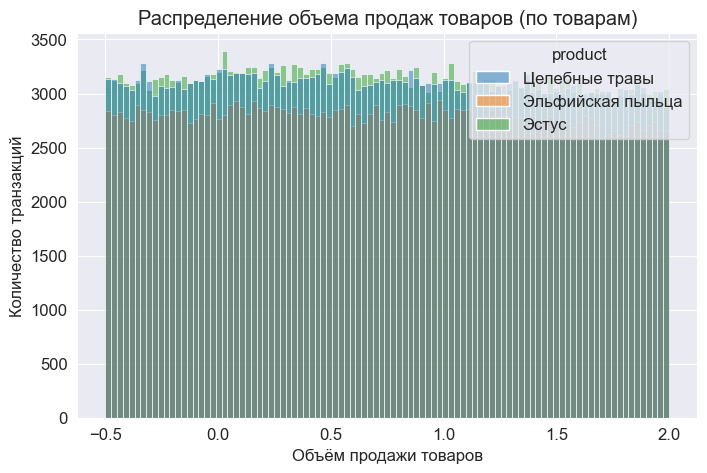

In [196]:
#Посмотрим на распределение amount
sns.histplot( data=df_transactions, x='amount', hue='product')
plt.title('Распределение объема продаж товаров (по товарам)')
plt.xlabel('Объём продажи товаров')
plt.ylabel('Количество транзакций')

Text(0, 0.5, 'Количество транзакций')

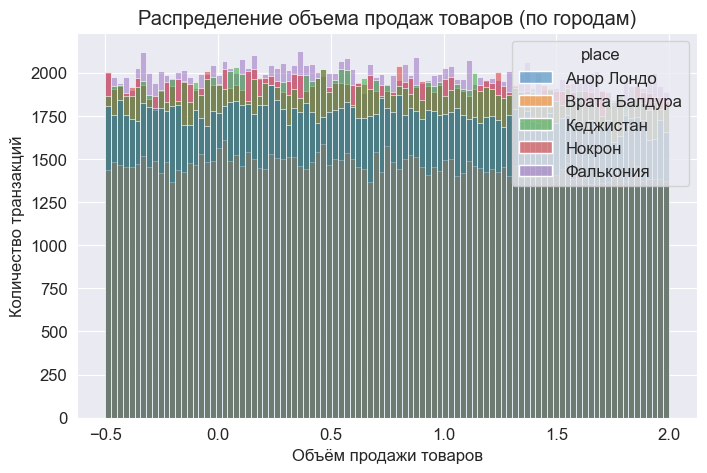

In [197]:
sns.histplot(data=df_transactions, x='amount', hue='place')
plt.title('Распределение объема продаж товаров (по городам)')
plt.xlabel('Объём продажи товаров')
plt.ylabel('Количество транзакций')

Text(0, 0.5, 'Количество транзакций')

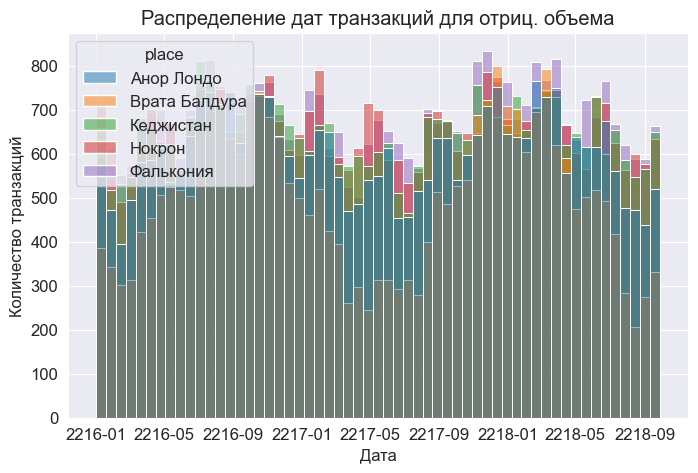

In [198]:
#Посмотрим на распределение дат транзакций, для которых amount отрицателен
sns.histplot(data=df_transactions[df_transactions['amount'] <= 0], x='datetime', hue='place')
plt.title('Распределение дат транзакций для отриц. объема')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')

Text(0, 0.5, 'Количество транзакций')

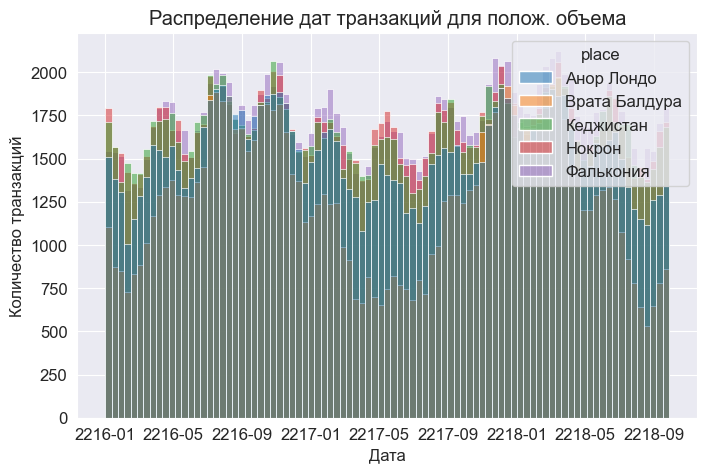

In [199]:
#Посмотрим общее распределение дат транзакций с положительным amount
sns.histplot(data=df_transactions[df_transactions['amount'] > 0], x='datetime', hue='place')
plt.title('Распределение дат транзакций для полож. объема')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')

+ Распределение `amount` похоже на равномерное. При этом для отрицательных показателей не наблюдается снижения количества записей. Это может означать, что ошибка __не заключается__ в случайной записи в таблицу значения со знаком минус. Поэтому мы не сможем взять модуль от столбца `amount`, так как это значительно повлияет на распределение. Так же отрицательные `amount` не зависят от места продажи и типа продукта, а их количество в таблице значительно - 20% от всех записей.
+ Из распределения количества транзакций по датам видна сильная сезонность, при этом в разных городах картина различается. Заметно, что сезонность не равна естественному годичному циклу в 12 месяцев.
+ Распределение `datetime` записей с отрицательным `amount` выглядит так же, как и для записей, у которых `amount` положителен.
+ Безопасным решением в данном случае будет удалить записи с отрицательным значением `amount`, да, мы лишимся 20% данных, но эти данные распределены равномерно и при этом не сгруппированы по датам, местам продажи и типу товара, а значит влияние на общую картину будет минимальным.


In [200]:
#Оставим записи с положительным amount
df_transactions = df_transactions[df_transactions['amount'] > 0]
df_transactions.describe()

,selling_price,amount,datetime
count,699477.000000,6.994770e+05,699477
mean,-300.197263,9.875246e-01,2217-05-16 22:10:17.537646592
min,-9998.990000,5.548802e-07,2216-01-02 00:08:00
25%,6.850000,4.874810e-01,2216-09-08 05:57:00
50%,9.730000,9.819558e-01,2217-05-17 17:04:00
75%,13.800000,1.483699e+00,2218-01-23 04:44:00
max,31.200000,1.999999e+00,2218-09-27 23:57:00
std,1408.223199,5.763921e-01,NaN


После удаления отрицательных значений видно, что в `amount` присутствуют записи с аномально низким значением для унций

In [201]:
#Возьмем одну тысячную унции как порог низкого значения и посмотрим на данные
df_transactions[df_transactions['amount'] < 1e-3]

,product,selling_price,amount,place,datetime
1598,Целебные травы,3.90,0.000787,Анор Лондо,2216-01-11 13:30:00
1619,Эльфийская пыльца,9.21,0.000163,Анор Лондо,2216-01-11 04:05:00
2226,Эльфийская пыльца,9.80,0.000760,Анор Лондо,2216-01-15 10:32:00
3333,Эльфийская пыльца,9.80,0.000689,Анор Лондо,2216-01-22 09:08:00
6417,Эльфийская пыльца,10.31,0.000559,Анор Лондо,2216-02-15 14:35:00
...,...,...,...,...,...
865238,Эстус,9.69,0.000870,Фалькония,2218-08-03 07:50:00
866824,Эстус,9.56,0.000386,Фалькония,2218-08-13 10:20:00
871219,Эльфийская пыльца,15.35,0.000369,Фалькония,2218-09-08 09:48:00
871439,Эльфийская пыльца,15.35,0.000011,Фалькония,2218-09-09 05:19:00


In [202]:
#Посмотрим, сколько товаров каждого типа в этих данных
df_transactions[df_transactions['amount'] < 1e-3]['product'].value_counts()

product
Эстус                135
Эльфийская пыльца    116
Целебные травы       112
Name: count, dtype: int64

Text(0, 0.5, 'Количество транзакций')

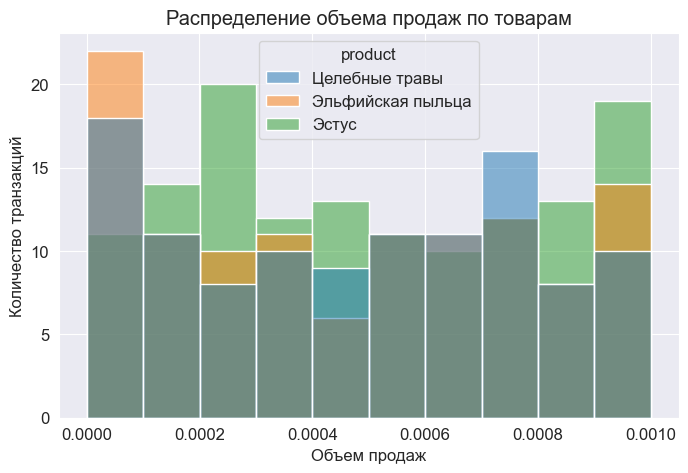

In [203]:
#Посмотрим, как эти данные распределены по городам и товарам
sns.histplot(data=df_transactions[df_transactions['amount'] < 1e-3], x='amount', hue='product')
plt.title('Распределение объема продаж по товарам')
plt.xlabel('Объем продаж')
plt.ylabel('Количество транзакций')

Text(0, 0.5, 'Количество транзакций')

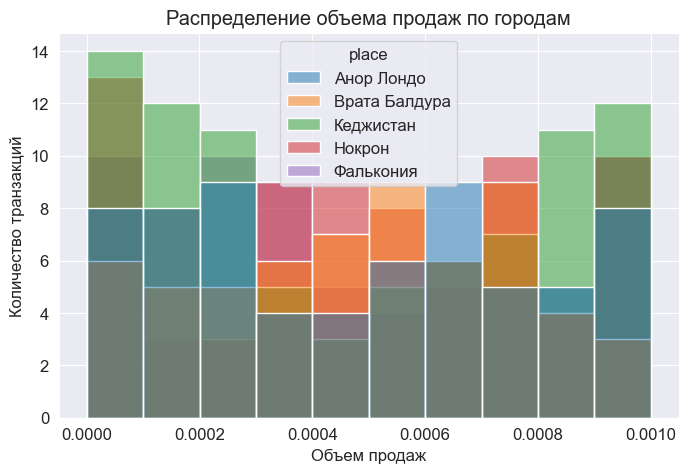

In [204]:
sns.histplot(data=df_transactions[df_transactions['amount'] < 1e-3], x='amount', hue='place')
plt.title('Распределение объема продаж по городам')
plt.xlabel('Объем продаж')
plt.ylabel('Количество транзакций')

Text(0, 0.5, 'Количество транзакций')

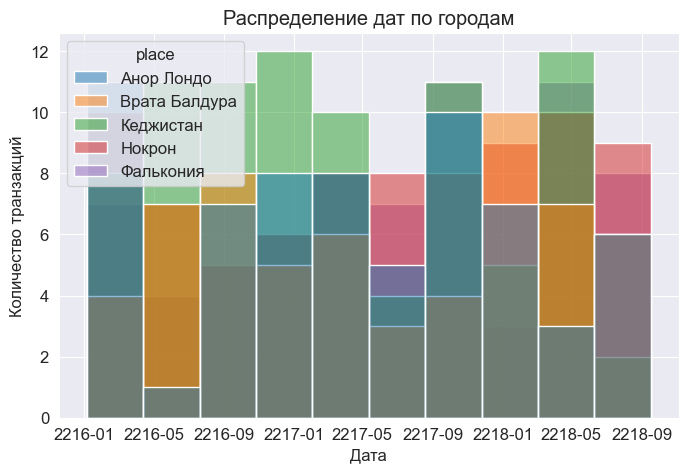

In [205]:
sns.histplot(data=df_transactions[df_transactions['amount'] < 1e-3], x='datetime', hue='place')
plt.title('Распределение дат по городам')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')

На графиках нет дисбаланса, который мог бы повлиять на будущие расчеты (например, если бы все эти значения были сконцентрированы в одном месте в один день, что потребовало бы дальнейшего анализа, является это ошибкой или закономерностью), поэтому хоть и с точки зрения интерпретации данных такие малые объемы продукта нелогичны, оставим эти значения в исходных данных.

При анализе данных за более чем 2 года и предсказании на 90 дней информация о времени совершения транзакции с точностью до минуты является излишней, поэтому сократим `datetime` до `date` и сгруппируем и аггрегируем данные по общему `amount` за день. Вместе с этим обработаем отрицательные значения в столбце `selling_price`.

In [206]:
#Оставим только информацию о дате и запишем ее в столбец date
df_transactions['date'] = df_transactions['datetime'].dt.normalize()
df_transactions.drop(labels='datetime', axis=1, inplace=True)
df_transactions

,product,selling_price,amount,place,date
0,Целебные травы,3.90,1.242125,Анор Лондо,2216-01-02
2,Целебные травы,3.90,0.882450,Анор Лондо,2216-01-02
3,Целебные травы,3.90,0.621377,Анор Лондо,2216-01-02
4,Целебные травы,3.90,1.367161,Анор Лондо,2216-01-02
5,Целебные травы,-7154.53,1.988265,Анор Лондо,2216-01-02
...,...,...,...,...,...
875031,Эстус,9.28,1.079104,Фалькония,2218-09-27
875032,Эстус,9.28,1.580617,Фалькония,2218-09-27
875033,Эстус,9.28,1.738492,Фалькония,2218-09-27
875034,Эстус,9.28,0.430340,Фалькония,2218-09-27


In [207]:
#Убедимся, что дата является экземляром класса Timestamp
df_transactions['date'][0]

Timestamp('2216-01-02 00:00:00')

Исправим отрицательные значения `selling_price` заменой их на предыдущие, нам это позволяет знание о формировании закона цены, а именно то, что цена может изменяться только раз в несколько дней.

In [208]:
#Аггрегируем данные по сумме amount
df_transactions_grouped_1 = df_transactions.groupby(['date', 'place','product'], as_index=False).agg({'amount':['sum']})
df_transactions_grouped_1.columns = ['date', 'place', 'product', 'amount']

#Посмотрим для примера на Эстус в Вратах Балдура
df_transactions_grouped_1[(df_transactions_grouped_1['place'] == 'Врата Балдура') & (df_transactions_grouped_1['product'] == 'Эстус')]

,date,place,product,amount
5,2216-01-02,Врата Балдура,Эстус,32.919055
20,2216-01-03,Врата Балдура,Эстус,32.177640
35,2216-01-04,Врата Балдура,Эстус,34.826636
50,2216-01-05,Врата Балдура,Эстус,31.179459
65,2216-01-06,Врата Балдура,Эстус,30.279028
...,...,...,...,...
14928,2218-09-23,Врата Балдура,Эстус,18.021374
14943,2218-09-24,Врата Балдура,Эстус,26.894850
14958,2218-09-25,Врата Балдура,Эстус,22.086726
14973,2218-09-26,Врата Балдура,Эстус,33.983057


In [209]:
#Аггрегируем данные о транзакциях с положительными значениями selling_price
df_transactions_grouped_2 = df_transactions[df_transactions['selling_price'] > 0.0].groupby(['date', 'place','product'], as_index=False).agg({'selling_price':['first']})
df_transactions_grouped_2.columns = ['date', 'place', 'product', 'selling_price']

#Посмотрим для примера на Эстус в Вратах Балдура
df_transactions_grouped_2[(df_transactions_grouped_2['place'] == 'Врата Балдура') & (df_transactions_grouped_2['product'] == 'Эстус')]

,date,place,product,selling_price
5,2216-01-02,Врата Балдура,Эстус,7.80
20,2216-01-03,Врата Балдура,Эстус,7.80
35,2216-01-04,Врата Балдура,Эстус,7.80
50,2216-01-05,Врата Балдура,Эстус,7.80
65,2216-01-06,Врата Балдура,Эстус,7.80
...,...,...,...,...
14928,2218-09-23,Врата Балдура,Эстус,20.22
14943,2218-09-24,Врата Балдура,Эстус,20.22
14958,2218-09-25,Врата Балдура,Эстус,20.33
14973,2218-09-26,Врата Балдура,Эстус,20.33


In [210]:
#Соединим таблицы
df_transactions_grouped_3 = pd.merge(df_transactions_grouped_1, df_transactions_grouped_2, how='left')

#Посмотрим для примера на Эстус в Вратах Балдура
df_transactions_grouped_3[(df_transactions_grouped_3['place'] == 'Врата Балдура') & (df_transactions_grouped_3['product'] == 'Эстус')]

,date,place,product,amount,selling_price
5,2216-01-02,Врата Балдура,Эстус,32.919055,7.80
20,2216-01-03,Врата Балдура,Эстус,32.177640,7.80
35,2216-01-04,Врата Балдура,Эстус,34.826636,7.80
50,2216-01-05,Врата Балдура,Эстус,31.179459,7.80
65,2216-01-06,Врата Балдура,Эстус,30.279028,7.80
...,...,...,...,...,...
14928,2218-09-23,Врата Балдура,Эстус,18.021374,20.22
14943,2218-09-24,Врата Балдура,Эстус,26.894850,20.22
14958,2218-09-25,Врата Балдура,Эстус,22.086726,20.33
14973,2218-09-26,Врата Балдура,Эстус,33.983057,20.33


In [211]:
#Проверим корректность merge
df_transactions_grouped_3.isna().sum()

date             0
place            0
product          0
amount           0
selling_price    0
dtype: int64

In [212]:
#Проверим отсутствие отрицательных значений в selling_price
df_transactions_grouped_3.describe()

,date,amount,selling_price
count,14998,14998.000000,14998.000000
mean,2217-05-15 11:59:36.956926976,46.033948,11.787178
min,2216-01-02 00:00:00,0.033510,2.730000
25%,2216-09-07 06:00:00,39.316813,7.690000
50%,2217-05-15 12:00:00,47.282230,10.530000
75%,2218-01-20 18:00:00,54.182061,14.810000
max,2218-09-27 00:00:00,75.592174,31.200000
std,NaN,11.325158,5.559799


Text(0, 0.5, 'Цена')

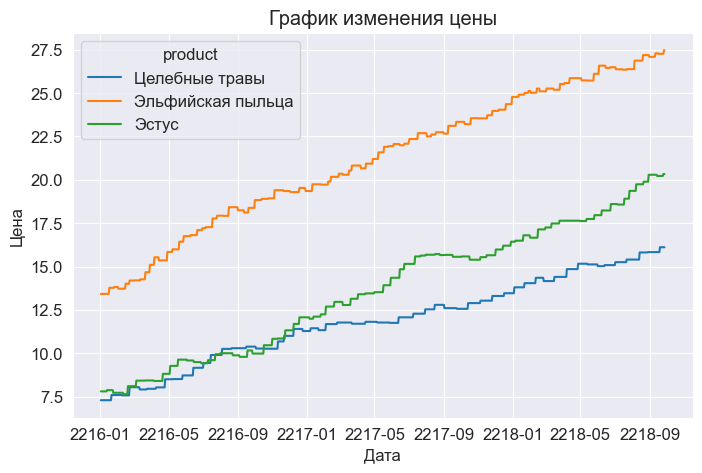

In [213]:
#Посмотрим на график и убедимся, что изменения цены не содержат ошибок
sns.lineplot(data=df_transactions_grouped_3[(df_transactions_grouped_3['place'] == 'Врата Балдура')],
             x='date',
             y='selling_price',
             hue='product')
plt.title('График изменения цены')
plt.xlabel('Дата')
plt.ylabel('Цена')

Text(0, 0.5, 'Объем продаж')

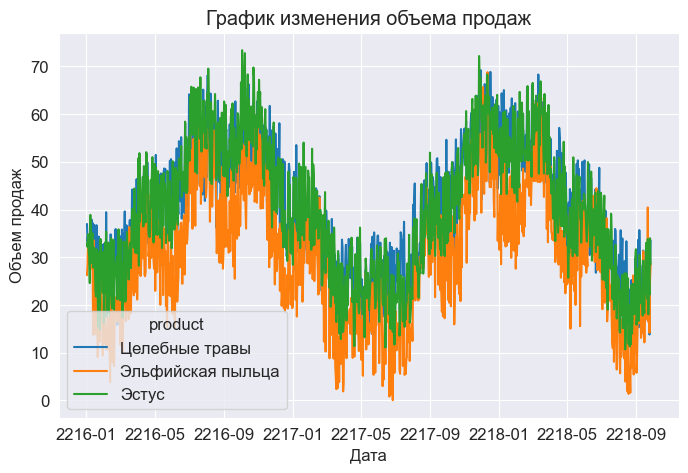

In [214]:
#Посмотрим на значения amount
sns.lineplot(df_transactions_grouped_3[df_transactions_grouped_3['place'] == 'Врата Балдура'],
             x='date',
             y='amount',
             hue='product')
plt.title('График изменения объема продаж')
plt.xlabel('Дата')
plt.ylabel('Объем продаж')

Из графика видно, что изменение `amount` носит сильный сезонный характер. Мы успешно сгруппировали данные и перешли от таблицы с 875 тыс. транзакций к 15 тыс. ежедневных данных об объеме проданных товаров и цене, на основе которых можно создать модель динамического ценообразования.

In [215]:
#Посмотрим на данные
df_transactions = df_transactions_grouped_3
df_transactions

,date,place,product,amount,selling_price
0,2216-01-02,Анор Лондо,Целебные травы,41.494198,3.90
1,2216-01-02,Анор Лондо,Эльфийская пыльца,53.764508,9.21
2,2216-01-02,Анор Лондо,Эстус,53.712552,3.60
3,2216-01-02,Врата Балдура,Целебные травы,36.977217,7.29
4,2216-01-02,Врата Балдура,Эльфийская пыльца,26.228956,13.42
...,...,...,...,...,...
14993,2218-09-27,Нокрон,Эльфийская пыльца,45.925935,18.11
14994,2218-09-27,Нокрон,Эстус,49.118360,9.97
14995,2218-09-27,Фалькония,Целебные травы,46.131862,10.97
14996,2218-09-27,Фалькония,Эльфийская пыльца,47.200902,15.28


In [216]:
#Посмотрим на диапазон дат
df_transactions['date'].max() - df_transactions['date'].min()

Timedelta('999 days 00:00:00')

В данных должно быть 1000 * 3 * 5 = 15000 записей, не хватает двух. Найдем пропуски.

In [217]:
places = ['Анор Лондо', 'Врата Балдура', 'Фалькония', 'Кеджистан', 'Нокрон']
products = ['Эстус', 'Эльфийская пыльца', 'Целебные травы']

for place in places:
    for product in products:
        print(df_transactions[(df_transactions['place'] == place) & (df_transactions['product'] == product)].shape, product, place)

(1000, 5) Эстус Анор Лондо
(1000, 5) Эльфийская пыльца Анор Лондо
(1000, 5) Целебные травы Анор Лондо
(1000, 5) Эстус Врата Балдура
(998, 5) Эльфийская пыльца Врата Балдура
(1000, 5) Целебные травы Врата Балдура
(1000, 5) Эстус Фалькония
(1000, 5) Эльфийская пыльца Фалькония
(1000, 5) Целебные травы Фалькония
(1000, 5) Эстус Кеджистан
(1000, 5) Эльфийская пыльца Кеджистан
(1000, 5) Целебные травы Кеджистан
(1000, 5) Эстус Нокрон
(1000, 5) Эльфийская пыльца Нокрон
(1000, 5) Целебные травы Нокрон


Два значения отсутствуют в паре (Эльфийская пыльца, Врата Балдура). Заполним их.

In [218]:
product = 'Эльфийская пыльца'
place = 'Врата Балдура'
df_to_fix = df_transactions[(df_transactions['place'] == place) & (df_transactions['product'] == product)].copy()
df_to_fix.reset_index(inplace=True, drop=True)
df_to_fix

,date,place,product,amount,selling_price
0,2216-01-02,Врата Балдура,Эльфийская пыльца,26.228956,13.42
1,2216-01-03,Врата Балдура,Эльфийская пыльца,28.397026,13.42
2,2216-01-04,Врата Балдура,Эльфийская пыльца,34.727956,13.42
3,2216-01-05,Врата Балдура,Эльфийская пыльца,29.022833,13.42
4,2216-01-06,Врата Балдура,Эльфийская пыльца,28.594924,13.42
...,...,...,...,...,...
993,2218-09-23,Врата Балдура,Эльфийская пыльца,16.474986,27.26
994,2218-09-24,Врата Балдура,Эльфийская пыльца,23.487651,27.26
995,2218-09-25,Врата Балдура,Эльфийская пыльца,14.165130,27.26
996,2218-09-26,Врата Балдура,Эльфийская пыльца,25.128170,27.47


In [219]:
#Найдем индекс одного из двух пропущенных чисел
df_to_fix['date'].diff().idxmax()

457

In [220]:
df_to_fix.iloc[455:458]

,date,place,product,amount,selling_price
455,2217-04-01,Врата Балдура,Эльфийская пыльца,3.641122,20.82
456,2217-04-02,Врата Балдура,Эльфийская пыльца,17.897556,20.82
457,2217-04-04,Врата Балдура,Эльфийская пыльца,13.293795,20.82


In [221]:
fix1 = df_to_fix.iloc[457:458].copy()
fix1['date'] = pd.Timestamp(2217, 4, 3, 0)
df_to_fix = pd.concat([df_to_fix, fix1], ignore_index=True).sort_values(by='date')
df_to_fix

,date,place,product,amount,selling_price
0,2216-01-02,Врата Балдура,Эльфийская пыльца,26.228956,13.42
1,2216-01-03,Врата Балдура,Эльфийская пыльца,28.397026,13.42
2,2216-01-04,Врата Балдура,Эльфийская пыльца,34.727956,13.42
3,2216-01-05,Врата Балдура,Эльфийская пыльца,29.022833,13.42
4,2216-01-06,Врата Балдура,Эльфийская пыльца,28.594924,13.42
...,...,...,...,...,...
993,2218-09-23,Врата Балдура,Эльфийская пыльца,16.474986,27.26
994,2218-09-24,Врата Балдура,Эльфийская пыльца,23.487651,27.26
995,2218-09-25,Врата Балдура,Эльфийская пыльца,14.165130,27.26
996,2218-09-26,Врата Балдура,Эльфийская пыльца,25.128170,27.47


In [222]:
#Найдем индекс второго пропущенного числа
df_to_fix['date'].diff().idxmax()

545

In [223]:
df_to_fix.iloc[543:547]

,date,place,product,amount,selling_price
542,2217-06-28,Врата Балдура,Эльфийская пыльца,16.056671,22.08
543,2217-06-29,Врата Балдура,Эльфийская пыльца,16.390930,22.08
544,2217-06-30,Врата Балдура,Эльфийская пыльца,5.748985,22.08
545,2217-07-02,Врата Балдура,Эльфийская пыльца,18.715556,22.35


In [224]:
fix2 = df_to_fix.iloc[546:547].copy()
fix2['date'] = pd.Timestamp(2217, 7, 1, 0)
fix2

,date,place,product,amount,selling_price
545,2217-07-01,Врата Балдура,Эльфийская пыльца,18.715556,22.35


In [225]:
df_transactions = pd.concat([df_transactions, fix1], ignore_index=True).sort_values(by='date')
df_transactions = pd.concat([df_transactions, fix2], ignore_index=True).sort_values(by='date')
df_transactions

,date,place,product,amount,selling_price
0,2216-01-02,Анор Лондо,Целебные травы,41.494198,3.90
14,2216-01-02,Кеджистан,Эльфийская пыльца,55.356629,9.05
13,2216-01-02,Анор Лондо,Эльфийская пыльца,53.764508,9.21
12,2216-01-02,Анор Лондо,Эстус,53.712552,3.60
11,2216-01-02,Врата Балдура,Целебные травы,36.977217,7.29
...,...,...,...,...,...
14985,2218-09-27,Фалькония,Целебные травы,46.131862,10.97
14984,2218-09-27,Фалькония,Эльфийская пыльца,47.200902,15.28
14998,2218-09-27,Врата Балдура,Эльфийская пыльца,28.664566,27.47
14991,2218-09-27,Врата Балдура,Эстус,28.542440,20.33


Два пропуска были найдены и успешно заменены соседними значениями.

## Обработка данных таблицы competitors

In [226]:
#Снова посмотрим на таблицу
df_competitors.head(5)

,place,product,competitor,price,date
0,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-04
1,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-05
2,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-06
3,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-09
5,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-11


In [227]:
#Посмотрим на диапазон дат
df_competitors['date'].max() - df_competitors['date'].min()

Timedelta('999 days 00:00:00')

В таблице данные представлены с различной периодичностью, но на том же диапазоне, что и в таблице транзакций. Необходимо провести интерполяцию цен на промежутке в 1000 дней. Для этого используем даты предыдущей таблицы `transactions`, а также для будущего использования уже на этом этапе создадим общую таблицу `total`.

In [228]:
#Создадим общую таблицу
df_total = df_transactions.copy()
#Выделим и отсортируем списки конкурентов, городов и продуктов для дальнейшего итерирования по ним
competitors = ['Арториас&Co', 'Длань господня', 'ЛилIT', 'Светлые Души']

places = ['Анор Лондо', 'Врата Балдура', 'Фалькония', 'Кеджистан', 'Нокрон']
places.sort()

products = ['Эстус', 'Эльфийская пыльца', 'Целебные травы']
products.sort()

#Проитерируемся по списку конкурентов
for i, competitor in enumerate(competitors):
    #Соединим таблицы transactions и competitors. Таким образом, мы перенесем значения о цене конкурента
    #на диапазон дат таблицы transactions, получив NaN для дат, которых нет в таблице competitors для
    #данного конкурента
    df_selected_comp = pd.merge(df_transactions[['place', 'product', 'date']],
                      df_competitors[(df_competitors['competitor'] == competitor)],
                      on=['place', 'product', 'date'],
                      how='left')
    df_selected_comp.pop('competitor')
    df_selected_comp.rename(columns={'price': f'price_comp_{i+1}'}, inplace=True)

    #Проитерируемся по спискам городов и продуктов, для каждого из которых заполним пропуски в данных с помощью методов ffill и bffill.
    df_selected_place_product = None
    for place in places:
        for product in products:
            if df_selected_place_product is None:
                df_selected_place_product = df_selected_comp[(df_selected_comp['place']==place) &
                                                             (df_selected_comp['product']==product)].ffill().bfill()
            else:
                df_selected_place_product = pd.concat([df_selected_place_product,
                                                       df_selected_comp[(df_selected_comp['place']==place) &
                                                                        (df_selected_comp['product']==product)].ffill().bfill()],
                                                      ignore_index=True)
    #Данные о ценах каждого конкурента добавим в отдельный столбец общей таблицы
    df_total = pd.merge(df_total, df_selected_place_product,
                      on=['place', 'product', 'date'],
                      how='left')

Text(0, 0.5, 'Цена')

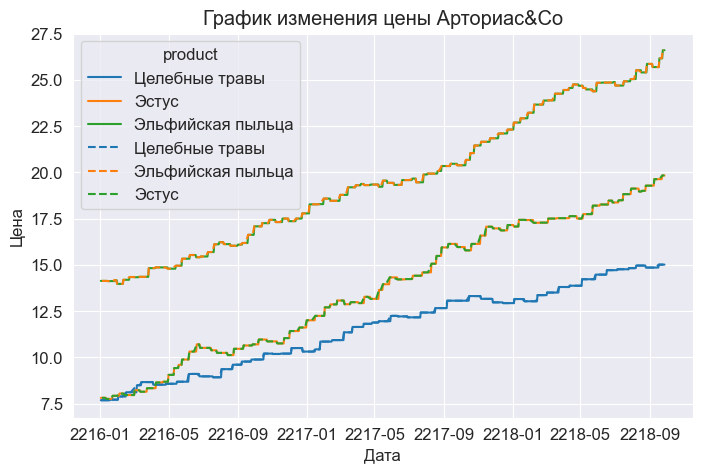

In [229]:
#Посмотрим для примера на цены конкурента Арториас&Co во Вратах Балдура
_, ax = plt.subplots(1)
sns.lineplot(data=df_total[(df_total['place'] == 'Врата Балдура')],
             ax=ax,
             x='date',
             y='price_comp_1',
             hue='product')
sns.lineplot(data=df_competitors[(df_competitors['place'] == 'Врата Балдура') &
                                 (df_competitors['competitor'] == 'Арториас&Co')],
             ax=ax,
             x='date',
             y='price',
             hue='product',
             linestyle='--')
plt.title('График изменения цены Арториас&Co')
plt.xlabel('Дата')
plt.ylabel('Цена')

Из графиков видно, что пропуски в данных отсутствуют, и цена теперь изменяется ступенчато на всем диапазоне дат.

## Обработка данных таблицы cost

Данные в таблице собраны с разной периодичностью, аналогично предыдущему пункту сделаем merge с таблицей total и интерполируем пропуски.

In [230]:
#Посмотрим на данные
df_cost.head()

,place,product,cost,date
0,Анор Лондо,Целебные травы,2.07,2216-01-02
1,Анор Лондо,Целебные травы,3.07,2216-01-26
2,Анор Лондо,Целебные травы,3.30,2216-02-12
3,Анор Лондо,Целебные травы,4.04,2216-03-06
4,Анор Лондо,Целебные травы,3.88,2216-03-27


In [231]:
df_to_merge = None
for place in places:
    for product in products:
        df_dates = df_total[(df_total['product'] == product) &
                            (df_total['place'] == place)][['date','place','product']].reset_index(drop=True)
        df_selected_place_product = df_cost[(df_cost['product'] == product) &
                                            (df_cost['place'] == place)]
        df_temp = pd.merge(df_dates, df_selected_place_product, on=['date', 'place', 'product'], how='left')
        #Интерполируем данные линейно, а не с помощью forward fill, как мы поступили с ценой
        df_temp.interpolate(method='linear', inplace=True)

        if df_to_merge is None:
            df_to_merge = df_temp
        else:
            df_to_merge = pd.concat([df_to_merge, df_temp], ignore_index=True)
        # Данные о ценах каждого конкурента добавим в отдельный столбец общей таблицы

df_total = pd.merge(df_total, df_to_merge,
                          on=['place', 'product', 'date'],
                          how='left')
df_total

,date,place,product,amount,selling_price,price_comp_1,price_comp_2,price_comp_3,price_comp_4,cost
0,2216-01-02,Анор Лондо,Целебные травы,41.494198,3.90,3.78,4.21,4.18,3.75,2.07
1,2216-01-02,Кеджистан,Эльфийская пыльца,55.356629,9.05,8.59,9.57,9.86,8.85,4.58
2,2216-01-02,Анор Лондо,Эльфийская пыльца,53.764508,9.21,9.79,9.67,8.88,9.03,3.46
3,2216-01-02,Анор Лондо,Эстус,53.712552,3.60,4.10,4.04,3.70,4.22,1.97
4,2216-01-02,Врата Балдура,Целебные травы,36.977217,7.29,7.68,7.81,8.01,8.66,3.63
...,...,...,...,...,...,...,...,...,...,...
14995,2218-09-27,Фалькония,Целебные травы,46.131862,10.97,11.29,15.03,14.75,10.90,4.58
14996,2218-09-27,Фалькония,Эльфийская пыльца,47.200902,15.28,16.32,20.86,18.55,20.94,11.77
14997,2218-09-27,Врата Балдура,Эльфийская пыльца,28.664566,27.47,26.60,25.93,27.49,24.63,21.68
14998,2218-09-27,Врата Балдура,Эстус,28.542440,20.33,19.83,20.80,21.97,17.99,7.86


Посмотрим на результат интерполяции на примере товаров во Вратах Балдура

Text(0, 0.5, 'Цена')

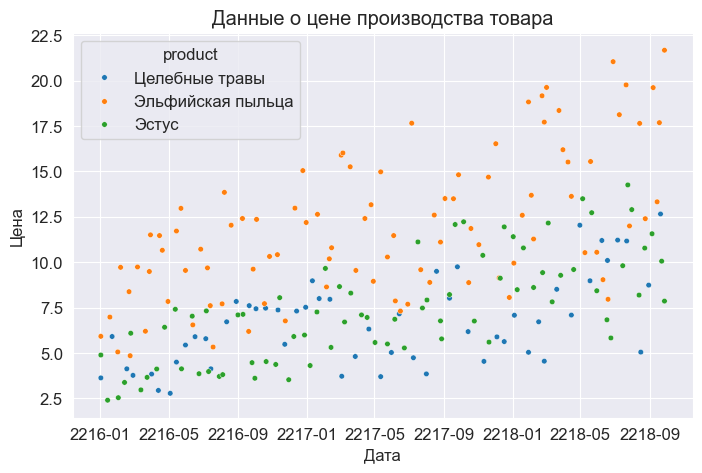

In [232]:
#Было
sns.scatterplot(data=df_cost[(df_cost['place'] == 'Врата Балдура')],
                x='date',
                y='cost',
                hue='product')
plt.title('Данные о цене производства товара')
plt.xlabel('Дата')
plt.ylabel('Цена')

Text(0, 0.5, 'Цена')

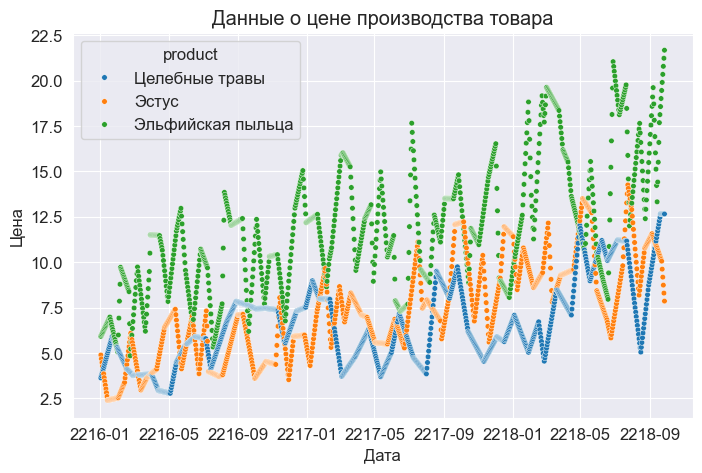

In [233]:
#Стало
sns.scatterplot(data=df_total[(df_total['place'] == 'Врата Балдура')],
                x='date',
                y='cost',
                hue='product')
plt.title('Данные о цене производства товара')
plt.xlabel('Дата')
plt.ylabel('Цена')

## Обработка данных таблицы *weather*

In [234]:
#Посмотрим на данные
df_weather.head(5)

,place,hot,rain,snow,date
0,Фалькония,0,0,0,2216-01-02
1,Анор Лондо,1,0,0,2216-01-02
2,Врата Балдура,0,0,1,2216-01-02
3,Нокрон,0,0,0,2216-01-02
4,Кеджистан,0,0,1,2216-01-02


Данные представлены в виде One-Hot Encoding, добавим столбец `anomaly`, который используем в дальнейшем.

In [235]:
#Столбец anomaly - хотя бы одно из состояний погоды hot, rain или snow
df_weather['anomaly'] = ~((df_weather['hot'] == 0) & (df_weather['rain'] == 0) & (df_weather['snow'] == 0))
df_weather['anomaly'] = df_weather['anomaly'].astype(int)

In [236]:
#Общая информация о таблице
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   place    5000 non-null   object        
 1   hot      5000 non-null   int64         
 2   rain     5000 non-null   int64         
 3   snow     5000 non-null   int64         
 4   date     5000 non-null   datetime64[ns]
 5   anomaly  5000 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(3), object(1)
memory usage: 215.0+ KB


In [237]:
#Посмотрим на диапазон дат
df_weather['date'].max() - df_weather['date'].min()

Timedelta('999 days 00:00:00')

In [238]:
#Узнаем, есть ли пропуски
df_weather['date'].diff().max()

Timedelta('1 days 00:00:00')

In [239]:
#Пропусков нет, сделаем merge с нашей общей таблицей
df_total = pd.merge(df_total, df_weather,
                      on=['place', 'date'],
                      how='left')

In [240]:
#Убедимся в отсутствии NaN
df_total.isna().sum()

date             0
place            0
product          0
amount           0
selling_price    0
price_comp_1     0
price_comp_2     0
price_comp_3     0
price_comp_4     0
cost             0
hot              0
rain             0
snow             0
anomaly          0
dtype: int64

# Создание модели динамического ценообразования
## Критерий качества

В качестве целевого результата необходимо максимизировать прибыль, которая считается по формуле __profit = price * amount - cost * amount = amount * (price - cost)__, то есть выручка минус расходы. Напишем функцию для расчета прибыли.

In [241]:
def profit(price, amount, cost):
    return np.sum(amount * (price - cost))

Рассчитаем для примера прибыль за последние 90 дней, которую принесли продажи Эстуса во Вратах Балдура.

In [242]:
place = 'Врата Балдура'
product = 'Эстус'

days = 90

df = df_total[(df_total['place'] == place) & (df_total['product'] == product)]
df = df[df['date'] >= (df.iloc[-1]['date'] - pd.Timedelta(days=(days - 1)))]

print(f"На товаре {product} в городе {place} за последние {days} дн. было заработано"
      f" {profit(df['selling_price'], df['amount'], df['cost']):.2f} зол.")

На товаре Эстус в городе Врата Балдура за последние 90 дн. было заработано 20122.25 зол.


## Архитектура

Предложим следующую архитектуру:
1) На основе имеющихся данных (день, цена, время, цены конкурентов, погода и др.) обучаем модель (одну на все комбинации товар/город, либо 15 разных) прогнозирования временного ряда с экзогенными признаками, таргет - объем продаж `amount`.
    + По данным, получаем с модели, рассчитывается критерий качества - прибыль `profit`.
2) На основе каких либо правил создаем массив цен-кандидатов.
    + Цены-кандидаты должны удовлетворять заданным ограничениям.
3) Делаем прогноз объема продаж на __n__ дней вперед.
    + Дополнительно, независимо от прогноза `amount`, прогнозируем все экзогенные признаки, необходимые для модели из п.1.
4) На основе массива цен рассчитываем критерий качества, выбираем лучшего кандидата, устанавливаем цену на товар на следущие __n__ дней.

Либо вместо п.2. и п.3. выполняем поиск лучшей цены численными методами оптимизации с ограничениями.



## Углубленный анализ и feature engineering

In [243]:
#Снова посмотрим на таблицу
df_total

,date,place,product,amount,selling_price,price_comp_1,price_comp_2,price_comp_3,price_comp_4,cost,hot,rain,snow,anomaly
0,2216-01-02,Анор Лондо,Целебные травы,41.494198,3.90,3.78,4.21,4.18,3.75,2.07,1,0,0,1
1,2216-01-02,Кеджистан,Эльфийская пыльца,55.356629,9.05,8.59,9.57,9.86,8.85,4.58,0,0,1,1
2,2216-01-02,Анор Лондо,Эльфийская пыльца,53.764508,9.21,9.79,9.67,8.88,9.03,3.46,1,0,0,1
3,2216-01-02,Анор Лондо,Эстус,53.712552,3.60,4.10,4.04,3.70,4.22,1.97,1,0,0,1
4,2216-01-02,Врата Балдура,Целебные травы,36.977217,7.29,7.68,7.81,8.01,8.66,3.63,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2218-09-27,Фалькония,Целебные травы,46.131862,10.97,11.29,15.03,14.75,10.90,4.58,0,0,0,0
14996,2218-09-27,Фалькония,Эльфийская пыльца,47.200902,15.28,16.32,20.86,18.55,20.94,11.77,0,0,0,0
14997,2218-09-27,Врата Балдура,Эльфийская пыльца,28.664566,27.47,26.60,25.93,27.49,24.63,21.68,1,0,0,1
14998,2218-09-27,Врата Балдура,Эстус,28.542440,20.33,19.83,20.80,21.97,17.99,7.86,1,0,0,1


Для создания модели нам нужно предсказать объем проданного товара на основании нашей цены на него.
Для этого нужно знать, эластичен ли спрос товара по цене, возможно, мы не можем поставить большую цену из-за падения спроса, а возможно, мы монополисты и можем поднять цену до максимально допустимой.
Посмотрим на изменение объема продаж `amount` с течением времени.

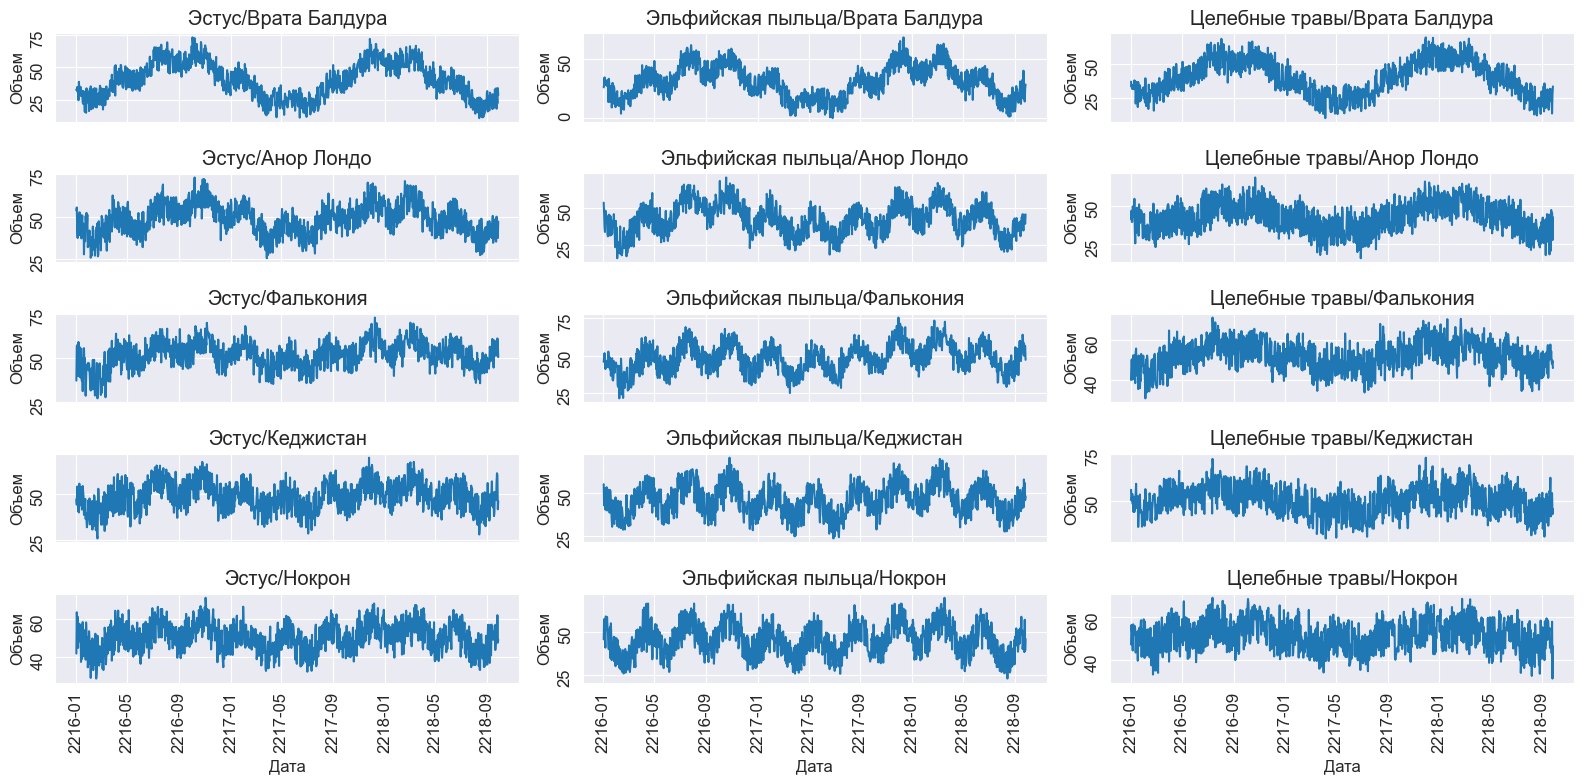

In [244]:
fig, axes = plt.subplots(5, 3, sharex=True, figsize=(16,8))
df = df_total.copy()

places = ['Врата Балдура', 'Анор Лондо', 'Фалькония', 'Кеджистан', 'Нокрон']
products = ['Эстус', 'Эльфийская пыльца', 'Целебные травы']

for i, place in enumerate(places):
    for j, product in enumerate(products):
        sns.lineplot(ax=axes[i, j],
                     data=df[(df['place'] == place) &
                             (df['product'] == product)],
                     x='date',
                     y='amount')
        axes[i, j].set_title(f'{product}/{place}')
        axes[i, j].set_xlabel('Дата')
        axes[i, j].set_ylabel('Объем')
        axes[i, j].tick_params(which='major', labelrotation=90)
fig.tight_layout()

Из графиков видно, что изменение `amount` носит сезонный характер с равными периодами, различными для каждого вида товаров. Поэтому ради упрощения будущей модели откажемся от представления города и товара в виде категориальных признаков и будем строить модель для каждого вида товара в каждом из городов.
Прежде чем рассматривать автокореляцию и сезонность проанализируем эластичность спроса от цены, допустим, на примере Эстуса во Вратах Балдура.

In [245]:
place = 'Врата Балдура'
product = 'Эстус'

df = df_total[(df_total['place'] == place) & (df_total['product'] == product)]
df.head()

,date,place,product,amount,selling_price,price_comp_1,price_comp_2,price_comp_3,price_comp_4,cost,hot,rain,snow,anomaly
5,2216-01-02,Врата Балдура,Эстус,32.919055,7.8,7.81,8.29,8.28,8.45,4.8900,0,0,1,1
15,2216-01-03,Врата Балдура,Эстус,32.177640,7.8,7.81,8.29,8.28,8.45,4.6825,0,0,1,1
36,2216-01-04,Врата Балдура,Эстус,34.826636,7.8,7.81,8.29,8.28,8.45,4.4750,0,1,0,1
45,2216-01-05,Врата Балдура,Эстус,31.179459,7.8,7.81,8.29,8.28,8.45,4.2675,1,0,0,1
60,2216-01-06,Врата Балдура,Эстус,30.279028,7.8,7.81,8.29,8.28,8.45,4.0600,0,0,1,1


Как мы можем определить влияние цены `selling_price` на объем продаж `amount`?
1) Корреляционный анализ `selling_price` и `amount`.
    Простейший способ, рассчитываем коэффициент корреляции и, сравнивая его с неким порогом, делаем выводы о взаимозависимости двух величин.

2) Анализ изменения объема `amount` и `selling_price` без учета инфляции.
    Если вычесть из графика цены инфляционный тренд, мы получим значения того, насколько изменение цены отличается от естественного инфляционного роста. Сравнивая эти изменения с изменениями объема продаж, можно сделать вывод о зависимостях.

In [246]:
#Построим матрицу корреляции для двух элементов
corr = df[['amount', 'selling_price']].corr()
print(f'Коэффициент корреляции между amount и selling_price для '
      f'{product} в {place} составляет {corr.values[0, 1]:.2f}')

Коэффициент корреляции между amount и selling_price для Эстус в Врата Балдура составляет -0.15


Значение коэффициента корреляции __corr = -0.15__ говорит нам о том, что цена и объем продаж практически не зависят друг от друга.
Будем считать порог начала слабой зависимости со значений в __+- 0.3__.

Посмотрим на изменение `amount` при изменении `selling_price` без учета инфляции.

In [247]:
#В качестве инфляции возьмем линейный тренд изменения цены за период наблюдения
#Получим этот тренд аппроксимацией значений цены полиномом 1 порядка
poly = np.polyfit(df.reset_index().index.values, y=df['selling_price'], deg=1)
trend = poly[0] * df.reset_index().index.values + poly[1]
trend

array([ 7.3408828 ,  7.35351394,  7.36614509,  7.37877623,  7.39140738,
        7.40403852,  7.41666967,  7.42930082,  7.44193196,  7.45456311,
        7.46719425,  7.4798254 ,  7.49245654,  7.50508769,  7.51771883,
        7.53034998,  7.54298113,  7.55561227,  7.56824342,  7.58087456,
        7.59350571,  7.60613685,  7.618768  ,  7.63139914,  7.64403029,
        7.65666144,  7.66929258,  7.68192373,  7.69455487,  7.70718602,
        7.71981716,  7.73244831,  7.74507945,  7.7577106 ,  7.77034175,
        7.78297289,  7.79560404,  7.80823518,  7.82086633,  7.83349747,
        7.84612862,  7.85875976,  7.87139091,  7.88402206,  7.8966532 ,
        7.90928435,  7.92191549,  7.93454664,  7.94717778,  7.95980893,
        7.97244007,  7.98507122,  7.99770237,  8.01033351,  8.02296466,
        8.0355958 ,  8.04822695,  8.06085809,  8.07348924,  8.08612038,
        8.09875153,  8.11138268,  8.12401382,  8.13664497,  8.14927611,
        8.16190726,  8.1745384 ,  8.18716955,  8.19980069,  8.21

Text(0, 0.5, 'Цена')

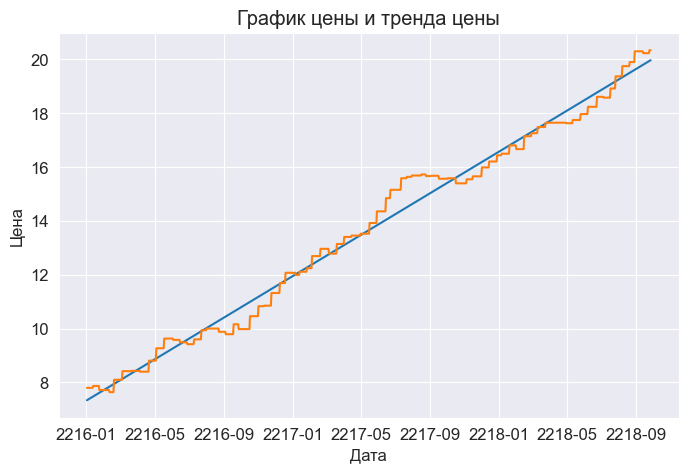

In [248]:
#Посмотрим на графики
sns.lineplot(data=df, x='date', y=trend)
sns.lineplot(data=df, x='date', y='selling_price')
plt.title('График цены и тренда цены')
plt.xlabel('Дата')
plt.ylabel('Цена')

В целом, принятый ранее закон изменения цены следует инфляции, сильно отходя от нее только около `2217-09`.
Посмотрим на изменения `amount`

In [249]:
#Рассчитаем, насколько цена отличается от тренда
df['delta'] = df['selling_price'] - trend
#Рассчитаем изменения amount при изменении selling_price
deltas = df[['amount', 'delta']].diff().drop_duplicates(subset=['delta'])[1:]
corr = deltas.corr()
print(f'Коэффициент корреляции между приращениями amount и selling_price для '
      f'{product} в {place} составляет {corr.values[0, 1]:.2f}')

Коэффициент корреляции между приращениями amount и selling_price для Эстус в Врата Балдура составляет 0.15


Значение __corr = 0.15__ говорит нам о том, что приращения практически не зависят друг от друга. Положительное значение корреляции опровергает предположение о том, что чем меньше цена, тем больше спрос.

Text(0, 0.5, 'Изменение цены')

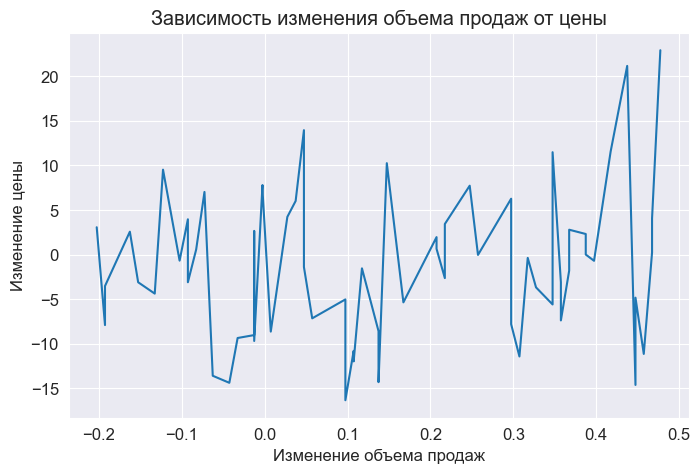

In [250]:
#Построим график
sns.lineplot(x=deltas['delta'],y=deltas['amount'])
plt.title('Зависимость изменения объема продаж от цены')
plt.xlabel('Изменение объема продаж')
plt.ylabel('Изменение цены')

Какую-либо закономерность в этих данных обнаружить сложно. За таковую можно посчитать рост в правой части графика, но как это трактовать? При положительном повышении цены поверх инфляции мы получаем рост проданного объема товаров. Это может говорить о том, что предыдущий закон цены адаптировался под спрос (чем больше должны купить товара, тем большая на него установлена цена), но никак не о том, что спрос зависит от установленной на него цены. Либо же, что более вероятно, данные зашумлены.

Text(0, 0.5, 'Цена/Объем')

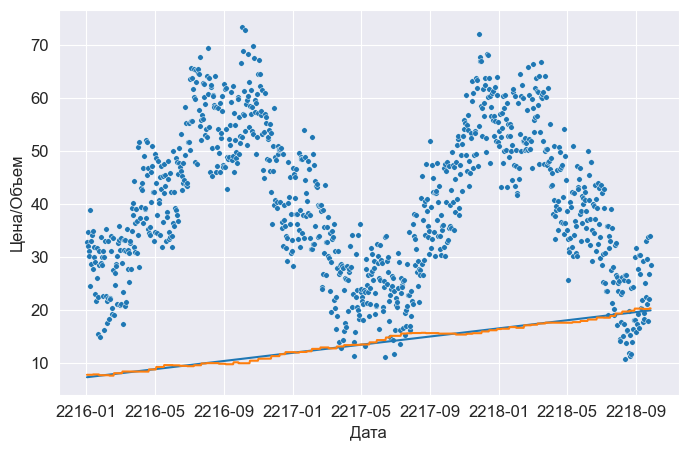

In [251]:
# Построим графики цены, тренда цены и объема продаж в одних осях
sns.lineplot(data=df, x='date', y=trend)
sns.lineplot(data=df, x='date', y='selling_price')
sns.scatterplot(data=df, x='date', y='amount')
plt.xlabel('Дата')
plt.ylabel('Цена/Объем')

Видно, что отход цены от тренда вниз случился после старта сезонного пика продаж, и в сам момент понижения цен наблюдался спад спроса. Похожая, но противоположная картина наблюдалась и в момент сезонного спада продаж.

Из всего перечисленного выше можно сделать вывод, что, как минимум для Эстуса во Вратах Балдура, __спрос от цены не зависит__, либо объема или точности данных недостаточно для выявления зависимости.

Повторим расчеты выше для всех городов и товаров.

In [252]:
places = ['Врата Балдура', 'Анор Лондо', 'Фалькония', 'Кеджистан', 'Нокрон']
products = ['Эстус', 'Эльфийская пыльца', 'Целебные травы']

#Проитерируемся по всем товарам по всех городах
for place in places:
    for product in products:
        df = df_total[(df_total['place'] == place) & (df_total['product'] == product)]
        corr = df[['amount', 'selling_price']].corr()
        #Если коэффицент корреляции больше порога, то есть зависимость
        if np.abs(corr.values[0, 1]) > 0.3:
            print(f'Найдена слабая зависимость между amount и selling_price для '
                  f'{product} в {place}')
            print(f'Коэффициент корреляции составляет {corr.values[0, 1]:.2f}')

        poly = np.polyfit(df.reset_index().index.values, y=df['selling_price'], deg=1)
        trend = poly[0] * df.reset_index().index.values + poly[1]

        df['delta'] = df['selling_price'] - trend
        #Рассчитаем изменения amount при изменении selling_price
        deltas = df[['amount', 'delta']].diff().drop_duplicates(subset=['delta'])[1:]
        corr = deltas.corr()
        if np.abs(corr.values[0, 1]) > 0.3:
            print(f'Найдена зависимость между приращениями amount и selling_price для '
                      f'{product} в {place}')
            print(f'Коэффициент корреляции составляет {corr.values[0, 1]:.2f}')

Найдена зависимость между приращениями amount и selling_price для Целебные травы в Врата Балдура
Коэффициент корреляции составляет -0.35


Коэффицент корреляции __corr = -0.35__ был найден для значений цены и объема продаж только одной пары (товар, город) из 15, но при этом корреляция приращений отсутствует. Этого мало для однозначных выводов.

Итак, мы пришли к выводу, что для наших товаров, представленных в различных городах, цена не влияет на спрос (либо объема или точности данных недостаточно для выявления зависимости). Это значительно усложняет процесс выбора цен, так как нашей будущей модели не удастся выявить прямые зависимости спроса от цены, из этого могут последовать проблемы:
 1) Нам придется рассматривать другие зависимости и генерировать признаки на основе цен конкурентов и погоды.
2) Когда мы обучим модель и будем предсказывать объем продаж на основе различных цен, мы будем считать прибыль как произведение этих двух величин. При этом, не выявив зависимость, мы рискуем попасть в ситуацию, когда мы поднимем цену настолько высоко, что в реальности товар перестанут покупать, так как промоделировать это не представляется возможности.

Построим матрицу корреляции и узнаем, какие признаки можно использовать для прогноза спроса на примере Эстуса во Вратах Балдура.

In [253]:
place = 'Врата Балдура'
product = 'Эстус'

df = df_total[(df_total['place'] == place) & (df_total['product'] == product)]

df.drop(['place', 'product', 'date'], axis=1, inplace=True)

df.corr()['amount']

amount           1.000000
selling_price   -0.147094
price_comp_1    -0.053066
price_comp_2    -0.066065
price_comp_3    -0.089347
price_comp_4    -0.066723
cost            -0.058777
hot              0.120732
rain             0.126085
snow             0.186213
anomaly          0.325482
Name: amount, dtype: float64

Из матрицы корреляции видно, что из имеющихся признаков спрос наиболее всего зависит от погоды, это можно использовать для дальнейшего построения модели.
Прямое влияние цен конкурентов на спрос также отсутствует. Из этого исходит необходимость в создании новых признаков.
Пользуясь логикой, придумаем несколько косвенных признаков, от которых может зависеть спрос:
+ max/min/mean_price_comp       - максимальная/минимальная/средняя цена по всем конкурентам на данный товар в данном городе
+ rel_max/min/mean_price_comp   - относительная разница между нашей и максимальной/минимальной/средней ценами конкурентов
+ rel_max/min/mean_price_comp**2 - квадрат относительных разниц, может облегчить моделилование нелинейности.
+ all_max/min/mean_price        -  максимальная/минимальная/средняя цена по всем предложениям (конкуренты + мы).
+ rel_all_max/min/mean_price    - относительная разница между нашей и максимальная/минимальная/средняя ценами по всем предложениям

In [254]:
#Функция создания экзогенных признаков
def create_exog(df):
    df = df.copy()

    df['max_price_comp'] = df[['price_comp_1', 'price_comp_2', 'price_comp_3', 'price_comp_4']].max(axis=1)
    df['min_price_comp'] = df[['price_comp_1', 'price_comp_2', 'price_comp_3', 'price_comp_4']].min(axis=1)
    df['mean_price_comp'] = df[['price_comp_1', 'price_comp_2', 'price_comp_3', 'price_comp_4']].mean(axis=1)

    df['rel_max_price_comp'] = (df['selling_price'] - df['max_price_comp']) / df['max_price_comp']
    df['rel_min_price_comp'] = (df['selling_price'] - df['min_price_comp']) / df['min_price_comp']
    df['rel_mean_price_comp'] = (df['selling_price'] - df['mean_price_comp']) / df['mean_price_comp']

    df['rel_max_price_comp**2'] =   df['rel_max_price_comp'] ** 2
    df['rel_min_price_comp**2'] =   df['rel_min_price_comp'] ** 2
    df['rel_mean_price_comp**2'] =  df['rel_mean_price_comp'] **2

    df['all_max_price'] = df[['selling_price', 'price_comp_1', 'price_comp_2', 'price_comp_3', 'price_comp_4']].max(axis=1)
    df['all_min_price'] = df[['selling_price', 'price_comp_1', 'price_comp_2', 'price_comp_3', 'price_comp_4']].min(axis=1)
    df['all_mean_price'] = df[['selling_price', 'price_comp_1', 'price_comp_2', 'price_comp_3', 'price_comp_4']].mean(axis=1)

    df['rel_all_max_price'] = (df['selling_price'] - df['all_max_price']) / df['all_max_price']
    df['rel_all_min_price'] = (df['selling_price'] - df['all_min_price']) / df['all_min_price']
    df['rel_all_mean_price'] = (df['selling_price'] - df['all_mean_price']) / df['all_mean_price']

    return df

# Посмотрим на сгенерированные признаки
df_total = create_exog(df_total)
df_total

,date,place,product,amount,selling_price,price_comp_1,price_comp_2,price_comp_3,price_comp_4,cost,...,rel_mean_price_comp,rel_max_price_comp**2,rel_min_price_comp**2,rel_mean_price_comp**2,all_max_price,all_min_price,all_mean_price,rel_all_max_price,rel_all_min_price,rel_all_mean_price
0,2216-01-02,Анор Лондо,Целебные травы,41.494198,3.90,3.78,4.21,4.18,3.75,2.07,...,-0.020101,5.421996e-03,0.001600,0.000404,4.21,3.75,3.964,-0.073634,0.040000,-0.016145
1,2216-01-02,Кеджистан,Эльфийская пыльца,55.356629,9.05,8.59,9.57,9.86,8.85,4.58,...,-0.018172,6.748639e-03,0.002868,0.000330,9.86,8.59,9.184,-0.082150,0.053551,-0.014591
2,2216-01-02,Анор Лондо,Эльфийская пыльца,53.764508,9.21,9.79,9.67,8.88,9.03,3.46,...,-0.014182,3.509867e-03,0.001381,0.000201,9.79,8.88,9.316,-0.059244,0.037162,-0.011378
3,2216-01-02,Анор Лондо,Эстус,53.712552,3.60,4.10,4.04,3.70,4.22,1.97,...,-0.103362,2.158532e-02,0.000730,0.010684,4.22,3.60,3.932,-0.146919,0.000000,-0.084435
4,2216-01-02,Врата Балдура,Целебные травы,36.977217,7.29,7.68,7.81,8.01,8.66,3.63,...,-0.093284,2.502680e-02,0.002579,0.008702,8.66,7.29,7.890,-0.158199,0.000000,-0.076046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2218-09-27,Фалькония,Целебные травы,46.131862,10.97,11.29,15.03,14.75,10.90,4.58,...,-0.155667,7.296828e-02,0.000041,0.024232,15.03,10.90,12.588,-0.270126,0.006422,-0.128535
14996,2218-09-27,Фалькония,Эльфийская пыльца,47.200902,15.28,16.32,20.86,18.55,20.94,11.77,...,-0.202817,7.305997e-02,0.004061,0.041135,20.94,15.28,18.390,-0.270296,0.000000,-0.169114
14997,2218-09-27,Врата Балдура,Эльфийская пыльца,28.664566,27.47,26.60,25.93,27.49,24.63,21.68,...,0.049976,5.293105e-07,0.013296,0.002498,27.49,24.63,26.424,-0.000728,0.115307,0.039585
14998,2218-09-27,Врата Балдура,Эстус,28.542440,20.33,19.83,20.80,21.97,17.99,7.86,...,0.009058,5.572211e-03,0.016919,0.000082,21.97,17.99,20.184,-0.074647,0.130072,0.007233


Рассмотрим для примера корреляцию `amount` c новыми признаками во Вратах Балдура на Эстус.

In [255]:
place = 'Врата Балдура'
product = 'Эстус'

df = df_total[(df_total['place'] == place) & (df_total['product'] == product)]

df.drop(['place', 'product', 'date'], axis=1, inplace=True)

df.corr()['amount']

amount                    1.000000
selling_price            -0.147094
price_comp_1             -0.053066
price_comp_2             -0.066065
price_comp_3             -0.089347
price_comp_4             -0.066723
cost                     -0.058777
hot                       0.120732
rain                      0.126085
snow                      0.186213
anomaly                   0.325482
max_price_comp           -0.081758
min_price_comp           -0.055927
mean_price_comp          -0.069252
rel_max_price_comp       -0.455375
rel_min_price_comp       -0.535162
rel_mean_price_comp      -0.530278
rel_max_price_comp**2     0.429691
rel_min_price_comp**2    -0.431543
rel_mean_price_comp**2    0.423879
all_max_price            -0.081758
all_min_price            -0.069368
all_mean_price           -0.085470
rel_all_max_price        -0.455375
rel_all_min_price        -0.540643
rel_all_mean_price       -0.529383
Name: amount, dtype: float64

Мы получили признаки с более сильной корреляцией с целевой переменной, чем имеющиеся раннее. При этом заметим, что для новых признаков
+ rel_max_price_comp = - 0.455375
+ rel_min_price_comp = - 0.535162
+ rel_mean_price_comp = - 0.530278
+ rel_max_price_comp2 = 0.429691
+ rel_min_price_comp2 = - 0.431543
+ rel_mean_price_comp2 = 0.423879

корреляция не всегда постоянного знака (у линейных она всегда отрицательна). Это может облегчить поиск оптимальной цены, так как может быть выявлен оптимум цены по объему продаж между максимальной, минимальной и средней.

Последним шагом рассмотрим автокорреляцию `amount`. Для примера снова рассмотрим Эстус во Вратах Балдура.

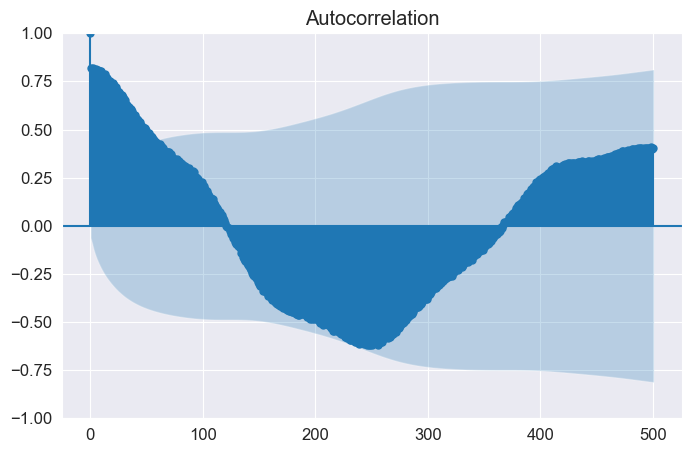

In [256]:
plot_acf(x=df['amount'], lags=500)
pass

На графике видна сильная автокорреляция, как минимум первые 60 лагов могут быть предсказаны с высокой точностью.

## Предсказание затрат на производство товара

Для успешного расчета прибыли нам нужна информация о цене на производство товар, что потребует предсказание на такой же временной отрезок. Перед нами классическая задач предсказания временного ряда без внешних признаков, так как, помимо инфляции (которая будет учтена в тренде) и, возможно, сезонности, никакие другие переменные, информацией о которых мы обладаем, на цену производства не влияют. Тем не менее, посмотрим на корреляцию:

In [257]:
df.corr()['cost']

amount                   -0.058777
selling_price             0.799528
price_comp_1              0.803839
price_comp_2              0.814241
price_comp_3              0.800185
price_comp_4              0.809670
cost                      1.000000
hot                       0.015529
rain                     -0.007281
snow                     -0.022354
anomaly                  -0.011223
max_price_comp            0.806956
min_price_comp            0.811977
mean_price_comp           0.809656
rel_max_price_comp        0.416942
rel_min_price_comp        0.396853
rel_mean_price_comp       0.447007
rel_max_price_comp**2    -0.438121
rel_min_price_comp**2     0.223834
rel_mean_price_comp**2   -0.464150
all_max_price             0.806956
all_min_price             0.812959
all_mean_price            0.808570
rel_all_max_price         0.416942
rel_all_min_price         0.337512
rel_all_mean_price        0.448699
Name: cost, dtype: float64

Видна очень сильная положительная корреляция между ценой на производство и ценой продажи и у нас, и у конкурентов. Это логически объясняется инфляцией - чем больше затраты на производство, тем больше нужно поставить цену для получения прибыли.

Напишем несколько функций, которые используем в дальнейшем.

In [258]:
#Функция разделения временного ряда на обучающую/тестовую выборки
def ts_train_test_split(df, label, days):
    df_train = df[df[label] <  (df.iloc[-1][label] - pd.Timedelta(days=(days-1)))]
    df_test =  df[df[label] >= (df.iloc[-1][label] - pd.Timedelta(days=(days-1)))]
    return df_train, df_test

#Функция, которая превращает колонку с датами в индекс класса DateTimeIndex
def preproc(df, label):
    df = df.copy()
    df = df.set_index(pd.DatetimeIndex(df[label]))
    df.pop(label)
    df = df.groupby(df.index).first()
    df.index.freq = 'd'
    return df

In [259]:
#Выполним разделение
df_total_train, df_total_test = ts_train_test_split(df_total, 'date', days)
df_total_test

,date,place,product,amount,selling_price,price_comp_1,price_comp_2,price_comp_3,price_comp_4,cost,...,rel_mean_price_comp,rel_max_price_comp**2,rel_min_price_comp**2,rel_mean_price_comp**2,all_max_price,all_min_price,all_mean_price,rel_all_max_price,rel_all_min_price,rel_all_mean_price
13650,2218-06-30,Кеджистан,Эльфийская пыльца,59.519667,28.32,30.27,28.88,29.50,30.69,16.710000,...,-0.050779,5.963523e-03,0.000376,0.002579,30.69,28.32,29.532,-0.077224,0.000000,-0.041040
13651,2218-06-30,Анор Лондо,Эльфийская пыльца,43.892510,18.68,17.11,16.04,22.36,20.01,7.750000,...,-0.010593,2.708645e-02,0.027089,0.000112,22.36,16.04,18.840,-0.164580,0.164589,-0.008493
13652,2218-06-30,Анор Лондо,Эстус,39.580157,9.62,7.94,9.36,10.59,15.86,6.200000,...,-0.120457,1.547971e-01,0.044769,0.014510,15.86,7.94,10.674,-0.393443,0.211587,-0.098745
13653,2218-06-30,Врата Балдура,Целебные травы,27.880053,15.08,14.71,14.95,15.45,16.43,10.846667,...,-0.019825,6.751378e-03,0.000633,0.000393,16.43,14.71,15.324,-0.082167,0.025153,-0.015923
13654,2218-06-30,Врата Балдура,Эльфийская пыльца,26.869678,26.49,24.88,24.90,26.30,24.42,20.519091,...,0.054328,5.219101e-05,0.007185,0.002952,26.49,24.42,25.398,0.000000,0.084767,0.042996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2218-09-27,Фалькония,Целебные травы,46.131862,10.97,11.29,15.03,14.75,10.90,4.580000,...,-0.155667,7.296828e-02,0.000041,0.024232,15.03,10.90,12.588,-0.270126,0.006422,-0.128535
14996,2218-09-27,Фалькония,Эльфийская пыльца,47.200902,15.28,16.32,20.86,18.55,20.94,11.770000,...,-0.202817,7.305997e-02,0.004061,0.041135,20.94,15.28,18.390,-0.270296,0.000000,-0.169114
14997,2218-09-27,Врата Балдура,Эльфийская пыльца,28.664566,27.47,26.60,25.93,27.49,24.63,21.680000,...,0.049976,5.293105e-07,0.013296,0.002498,27.49,24.63,26.424,-0.000728,0.115307,0.039585
14998,2218-09-27,Врата Балдура,Эстус,28.542440,20.33,19.83,20.80,21.97,17.99,7.860000,...,0.009058,5.572211e-03,0.016919,0.000082,21.97,17.99,20.184,-0.074647,0.130072,0.007233


Попробуем предсказать цену на производство Эстуса во Вратах Балдура на 90 дней вперед.
Выполним сплит и обработку данных.

In [260]:
place = 'Врата Балдура'
product = 'Эстус'

df_train = df_total_train[(df_total_train['place'] == place) & (df_total_train['product'] == product)]
df_train = preproc(df_train, label='date')

df_test = df_total_test[(df_total_test['place'] == place) & (df_total_test['product'] == product)]
df_test = preproc(df_test, label='date')

df_test

,place,product,amount,selling_price,price_comp_1,price_comp_2,price_comp_3,price_comp_4,cost,hot,...,rel_mean_price_comp,rel_max_price_comp**2,rel_min_price_comp**2,rel_mean_price_comp**2,all_max_price,all_min_price,all_mean_price,rel_all_max_price,rel_all_min_price,rel_all_mean_price
date,,,,,,,,,,,,,,,,,,,,,
2218-06-30,Врата Балдура,Эстус,33.842839,18.60,18.37,20.61,19.53,17.97,6.967143,0,...,-0.027197,0.009511,0.001229,0.000740,20.61,17.97,19.016,-0.097525,0.035058,-0.021876
2218-07-01,Врата Балдура,Эстус,43.519503,18.60,18.37,20.61,19.53,17.97,7.156667,0,...,-0.027197,0.009511,0.001229,0.000740,20.61,17.97,19.016,-0.097525,0.035058,-0.021876
2218-07-02,Врата Балдура,Эстус,42.045389,18.60,18.37,20.61,19.97,17.97,7.346190,1,...,-0.032761,0.009511,0.001229,0.001073,20.61,17.97,19.104,-0.097525,0.035058,-0.026382
2218-07-03,Врата Балдура,Эстус,28.473211,18.60,18.37,20.61,19.97,17.97,7.535714,0,...,-0.032761,0.009511,0.001229,0.001073,20.61,17.97,19.104,-0.097525,0.035058,-0.026382
2218-07-04,Врата Балдура,Эстус,25.299835,18.60,18.37,20.61,19.97,17.97,7.725238,0,...,-0.032761,0.009511,0.001229,0.001073,20.61,17.97,19.104,-0.097525,0.035058,-0.026382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218-09-23,Врата Балдура,Эстус,18.021374,20.22,19.83,20.80,21.62,17.99,9.620000,0,...,0.007976,0.004193,0.015366,0.000064,21.62,17.99,20.092,-0.064755,0.123958,0.006371
2218-09-24,Врата Балдура,Эстус,26.894850,20.22,19.83,20.80,21.62,17.99,9.180000,0,...,0.007976,0.004193,0.015366,0.000064,21.62,17.99,20.092,-0.064755,0.123958,0.006371
2218-09-25,Врата Балдура,Эстус,22.086726,20.33,19.83,20.80,21.97,17.99,8.740000,0,...,0.009058,0.005572,0.016919,0.000082,21.97,17.99,20.184,-0.074647,0.130072,0.007233


Для прогнозирования цены воспользуемся модулем Prophet от Meta, который основан на разложении нашего временного ряда в ряд Фурье. Можно было воспользоваться, например, ARIMA или градиентным бустингом с учетом лагов, но в отсутствии необходимости учитывать внешние признаки, а также необходимости обработки данных (например, обеспечение стационарности) и потенциальной сложности подборов коэффициентов у ARIMA, воспользуемся Prophet как самым легким решением.

В качестве метрик используем MAPE и RMSE. Построим несколько моделей.
Первый вариант - с учетом сезонности и на интерполированных значениях:

prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


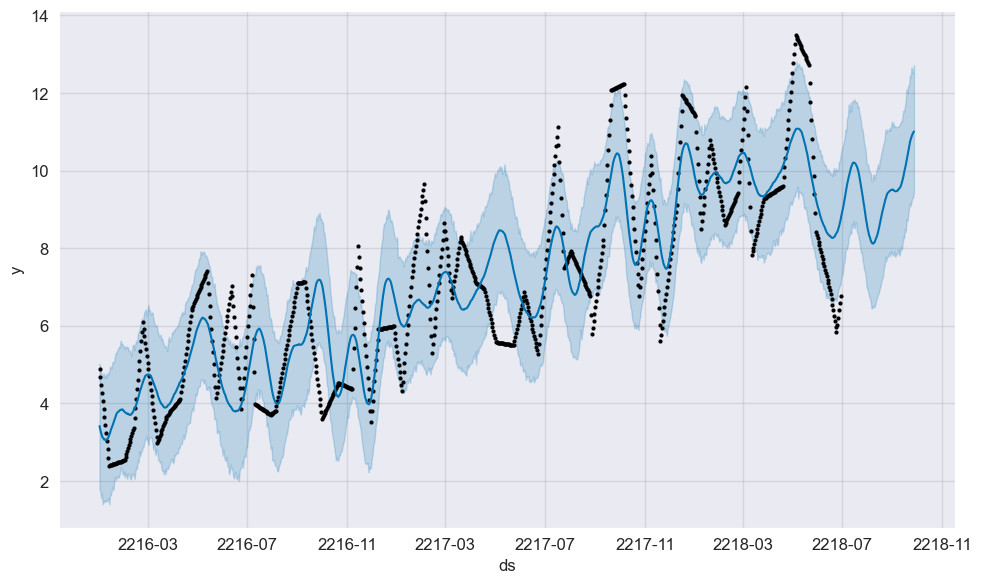

In [261]:
#Отключим вывод логов
logging.getLogger("cmdstanpy").disabled=True

target = 'cost'
#Для Prophet обязательно именовать столбцы даты и целевой переменной
#как 'ds' и 'y' соответственно
df_prophet_train = df_train.reset_index()[['date', target]]
df_prophet_train.columns=['ds', 'y']
df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])

#Инициализируем модель и сделаем fit predict
m = Prophet()
m.fit(df_prophet_train)
#Метод make_future_dataframe создаем датафрейм с индексами на N дней вперед
future = m.make_future_dataframe(periods=days)
forecast_prophet = m.predict(future)

#Построим графики
fig1 = m.plot(forecast_prophet)
#Возможно построить график компонент
# fig2 = m.plot_components(forecast_prophet)

In [262]:
print(f"MAPE: {mean_absolute_percentage_error(forecast_prophet['yhat'].tail(90), df_test[target]):.2}")
print(f"RMSE: {np.sqrt(mean_squared_error(forecast_prophet['yhat'].tail(90), df_test[target])):.3}")

MAPE: 0.19
RMSE: 2.13


Второй вариант - только тренд на интерполированных значениях:

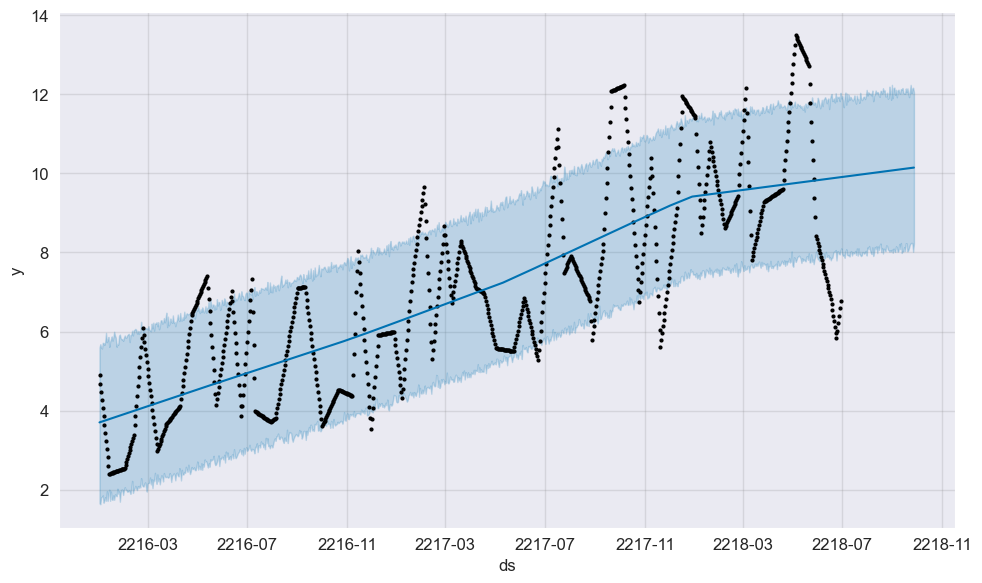

In [263]:
#Инициализируем модель и сделаем fit predict
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False)
m.fit(df_prophet_train)
#Метод make_future_dataframe создаем датафрейм с индексами на N дней вперед
future = m.make_future_dataframe(periods=days)
forecast_prophet = m.predict(future)

#Построим графики
fig1 = m.plot(forecast_prophet)
#Возможно построить график компонент
# fig2 = m.plot_components(forecast_prophet)

In [264]:
print(f"MAPE: {mean_absolute_percentage_error(forecast_prophet['yhat'].tail(90), df_test[target]):.2}")
print(f"RMSE: {np.sqrt(mean_squared_error(forecast_prophet['yhat'].tail(90), df_test[target])):.3}")

MAPE: 0.14
RMSE: 1.74


Третий вариант - с учетом сезонности и на исходных значениях:

prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


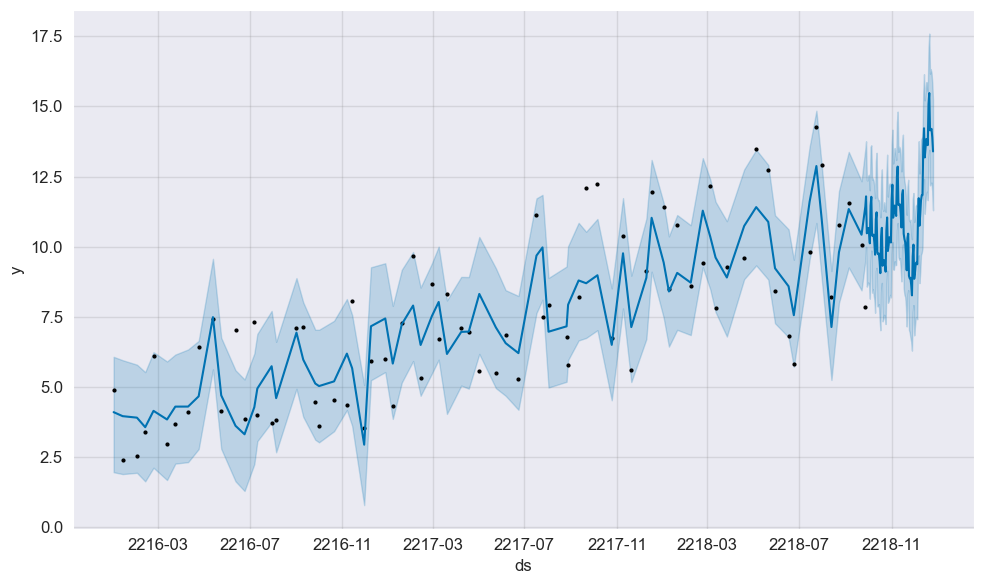

In [265]:
df_prophet_train = df_cost[(df_cost['place'] == place) & (df_cost['product'] == product)].reset_index()[['date',target]]
#Для Prophet обязательно именовать столбцы даты и целевой переменной
#как 'ds' и 'y' соответственно
df_prophet_train.columns=['ds', 'y']
df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])

#Инициализируем модель и сделаем fit predict
m = Prophet()
m.fit(df_prophet_train)

#Метод make_future_dataframe создаем датафрейм с индексами на N дней вперед
future = m.make_future_dataframe(periods=days)
forecast_prophet = m.predict(future)

#Построим графики
fig1 = m.plot(forecast_prophet)
#Возможно построить график компонент
# fig2 = m.plot_components(forecast_prophet)

In [266]:
print(f"MAPE: {mean_absolute_percentage_error(forecast_prophet['yhat'].tail(90), df_test[target]):.2}")
print(f"RMSE: {np.sqrt(mean_squared_error(forecast_prophet['yhat'].tail(90), df_test[target])):.3}")

MAPE: 0.21
RMSE: 2.77


Четвертый вариант - только тренд на исходных значениях:

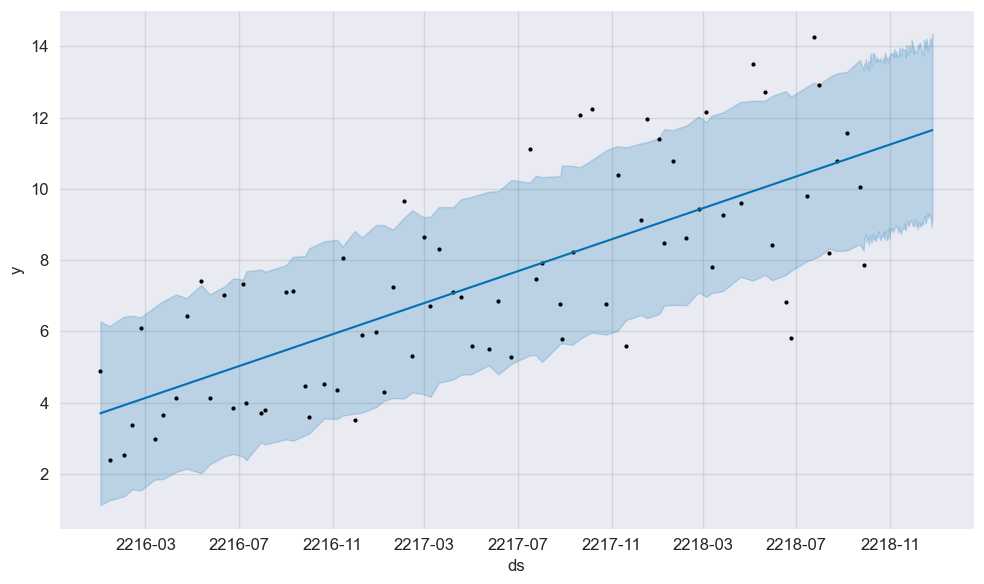

In [267]:
#Инициализируем модель и сделаем fit predict
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False)
m.fit(df_prophet_train)

#Метод make_future_dataframe создаем датафрейм с индексами на N дней вперед
future = m.make_future_dataframe(periods=days)
forecast_prophet = m.predict(future)

#Построим графики
fig1 = m.plot(forecast_prophet)
#Возможно построить график компонент
# fig2 = m.plot_components(forecast_prophet)

In [268]:
print(f"MAPE: {mean_absolute_percentage_error(forecast_prophet['yhat'].tail(90), df_test[target]):.2}")
print(f"RMSE: {np.sqrt(mean_squared_error(forecast_prophet['yhat'].tail(90), df_test[target])):.3}")

MAPE: 0.14
RMSE: 1.88


Лучшие показатели MAPE = 0.14 и RMSE = 1.8 у моделей, где мы предсказываем только тренд.

## Предсказание цен конкурентов

Попробуем предсказать цены конкурентов на Эстус во Вратах Балдура.

In [269]:
place = 'Врата Балдура'
product = 'Эстус'

df = df_total[(df_total['place'] == place) & (df_total['product'] == product)]

Text(0, 0.5, 'Дата')

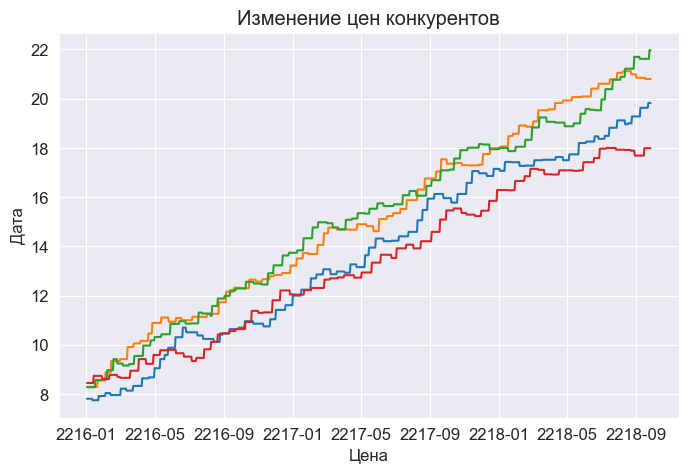

In [270]:
#Посмотрим на изменение цен конкурентов
sns.lineplot(x=df['date'], y=df['price_comp_1'])
sns.lineplot(x=df['date'], y=df['price_comp_2'])
sns.lineplot(x=df['date'], y=df['price_comp_3'])
sns.lineplot(x=df['date'], y=df['price_comp_4'])
plt.title('Изменение цен конкурентов')
plt.xlabel('Цена')
plt.ylabel('Дата')

Text(0, 0.5, 'Дата')

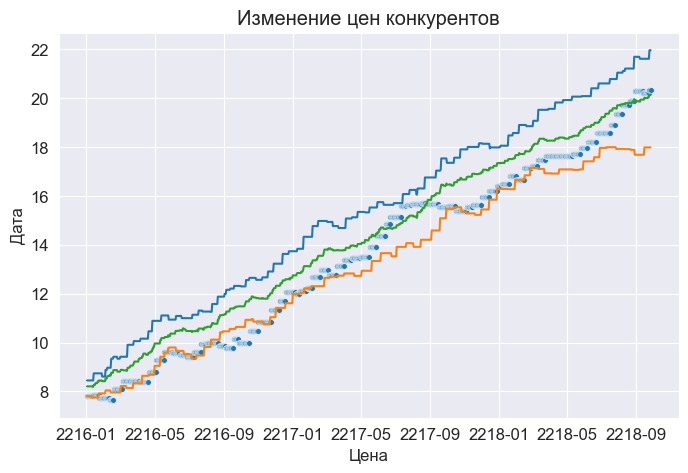

In [271]:
#Посмотрим на изменение mix/min/mean и нашей цены
sns.scatterplot(x=df['date'], y=df['selling_price'])
sns.lineplot(x=df['date'], y=df['max_price_comp'])
sns.lineplot(x=df['date'], y=df['min_price_comp'])
sns.lineplot(x=df['date'], y=df['mean_price_comp'])
plt.title('Изменение цен конкурентов')
plt.xlabel('Цена')
plt.ylabel('Дата')

Вместо предсказаний цен каждого конкурента будем предсказывать max/min/mean, так как на основе них рассчитываются коррелирующие с `amount` признаки, при этом, как минимум для средней цены, предсказание будет точнее из-за большей линейности. Для предсказания max/min/mean конкурентов также воспользуемся Prophet.

prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


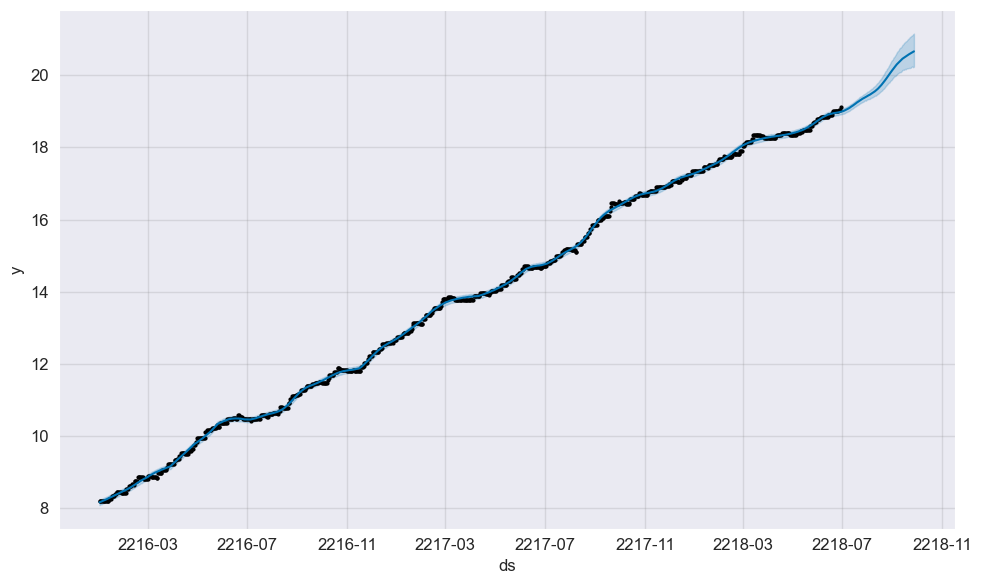

In [272]:
df_train = df_total_train[(df_total_train['place'] == place) & (df_total_train['product'] == product)]
df_test = df_total_test[(df_total_test['place'] == place) & (df_total_test['product'] == product)]

target = 'mean_price_comp'

#Для Prophet обязательно именовать столбцы даты и целевой переменной
#как 'ds' и 'y' соответственно
df_prophet_train = df_train.reset_index()[['date',target]]
df_prophet_train.columns=['ds', 'y']
df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])

#Инициализируем модель и сделаем fit predict
m = Prophet()
m.fit(df_prophet_train)

#Метод make_future_dataframe создаем датафрейм с индексами на N дней вперед
future = m.make_future_dataframe(periods=days)
forecast_prophet = m.predict(future)

#Построим графики
fig1 = m.plot(forecast_prophet)

In [273]:
print(f"MAPE: {mean_absolute_percentage_error(forecast_prophet['yhat'].tail(90), df_test[target]):.2}")
print(f"RMSE: {np.sqrt(mean_squared_error(forecast_prophet['yhat'].tail(90), df_test[target])):.3}")

MAPE: 0.014
RMSE: 0.319


prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


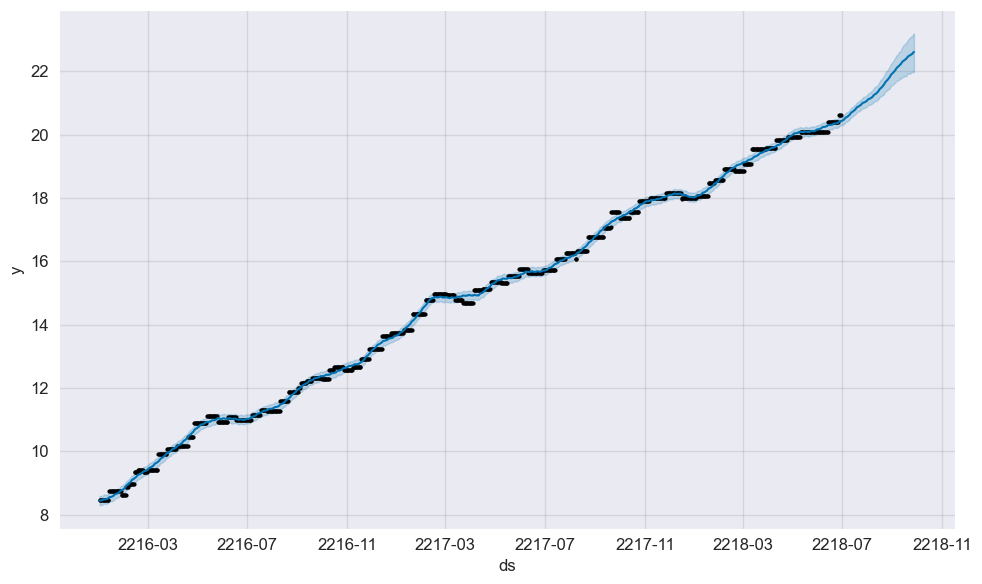

In [274]:
target = 'max_price_comp'

#Для Prophet обязательно именовать столбцы даты и целевой переменной
#как 'ds' и 'y' соответственно
df_prophet_train = df_train.reset_index()[['date',target]]
df_prophet_train.columns=['ds', 'y']
df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])

#Инициализируем модель и сделаем fit predict
m = Prophet()
m.fit(df_prophet_train)

#Метод make_future_dataframe создаем датафрейм с индексами на N дней вперед
future = m.make_future_dataframe(periods=days)
forecast_prophet = m.predict(future)

#Построим графики
fig1 = m.plot(forecast_prophet)

In [275]:
print(f"MAPE: {mean_absolute_percentage_error(forecast_prophet['yhat'].tail(90), df_test[target]):.2}")
print(f"RMSE: {np.sqrt(mean_squared_error(forecast_prophet['yhat'].tail(90), df_test[target])):.3}")

MAPE: 0.014
RMSE: 0.401


prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


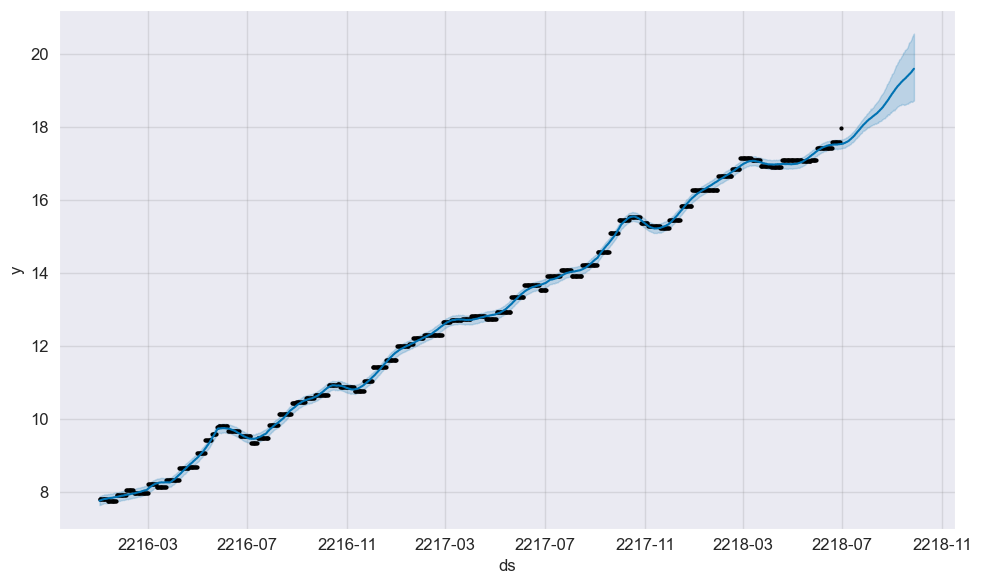

In [276]:
target = 'min_price_comp'

#Для Prophet обязательно именовать столбцы даты и целевой переменной
#как 'ds' и 'y' соответственно
df_prophet_train = df_train.reset_index()[['date',target]]
df_prophet_train.columns=['ds', 'y']
df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])

#Инициализируем модель и сделаем fit predict
m = Prophet()
m.fit(df_prophet_train)

#Метод make_future_dataframe создаем датафрейм с индексами на N дней вперед
future = m.make_future_dataframe(periods=days)
forecast_prophet = m.predict(future)

#Построим графики
fig1 = m.plot(forecast_prophet)

In [277]:
print(f"MAPE: {mean_absolute_percentage_error(forecast_prophet['yhat'].tail(90), df_test[target]):.2}")
print(f"RMSE: {np.sqrt(mean_squared_error(forecast_prophet['yhat'].tail(90), df_test[target])):.3}")

MAPE: 0.039
RMSE: 0.903


Из представленных выше метрик можно сделать вывод, что как минимум на 90 дней мы можем предсказывать max/min/mean цены конкурентов с высокой точностью.

## Предсказание погоды

Перед созданием модели ценообразования проверим, можем ли мы использовать знания о погоде в качестве признака и с приемлимой точностью сделать предсказания на 90 дней вперед.
Посмотрим на изменения погоды помесячно за период наблюдений, например, во Вратах Балдура.

Text(0, 0.5, 'Кол-во наблюдений')

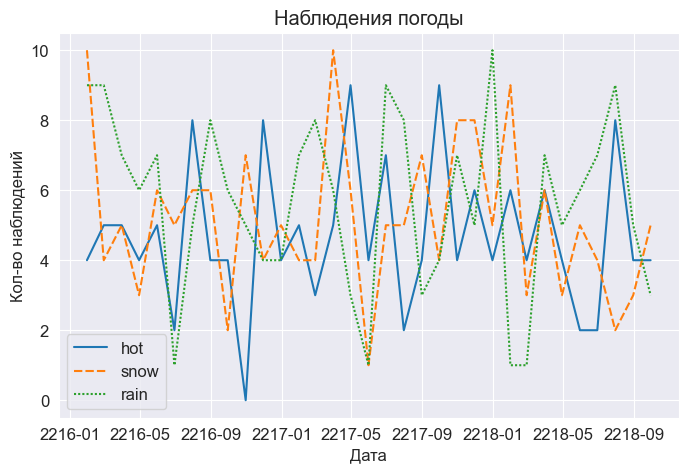

In [278]:
df = df_total.copy()
df = df[(df['place'] == 'Врата Балдура') & (df['product'] == 'Эстус')]
df_res = df.resample('M', on='date').sum()[['hot', 'snow', 'rain']]

sns.lineplot(df_res)
plt.title('Наблюдения погоды')
plt.xlabel('Дата')
plt.ylabel('Кол-во наблюдений')

По шкале y отмечено количество наблюдений каждого типа погоды за период измерений. Из графика видно, что в городе отсутствует очевидная сезонность изменения погоды - летом бывает снег, зимой жара. Посмотрим на графики автокореляции.

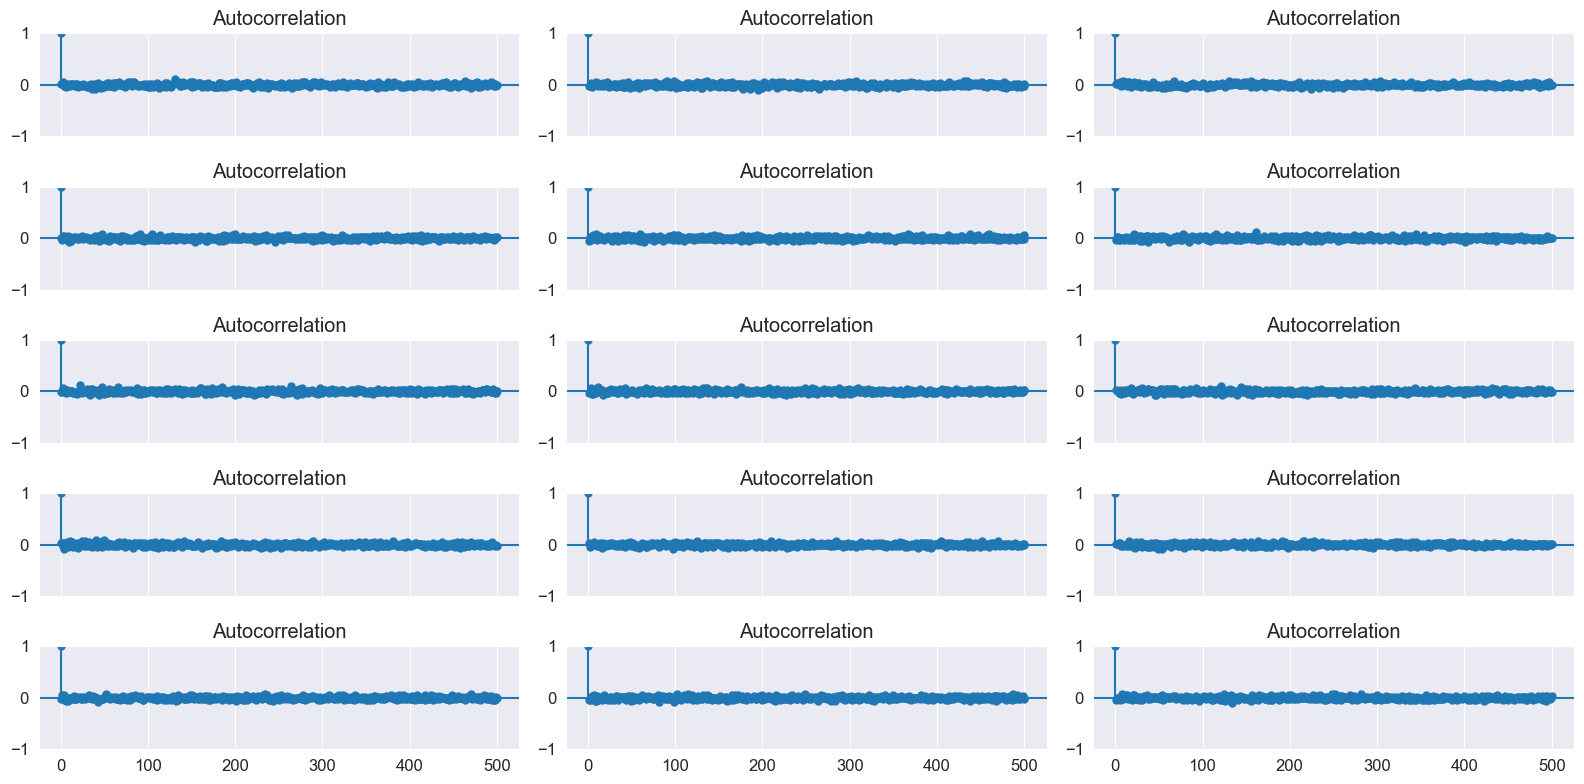

In [279]:
#Построим 15 графиков автокорреляции для каждого города и каждого типа погоды
fig, axes = plt.subplots(5, 3, sharex=True, figsize=(16,8))
df = df_total.copy()

plot_acf(ax=axes[0,0], x=df[(df['place'] == 'Врата Балдура') & (df['product'] == 'Эстус')]['hot'], lags=500)
plot_acf(ax=axes[1,0], x=df[(df['place'] == 'Анор Лондо') & (df['product'] == 'Эстус')]['hot'], lags=500)
plot_acf(ax=axes[2,0], x=df[(df['place'] == 'Фалькония') & (df['product'] == 'Эстус')]['hot'], lags=500)
plot_acf(ax=axes[3,0], x=df[(df['place'] == 'Кеджистан') & (df['product'] == 'Эстус')]['hot'], lags=500)
plot_acf(ax=axes[4,0], x=df[(df['place'] == 'Нокрон') & (df['product'] == 'Эстус')]['hot'], lags=500)

plot_acf(ax=axes[0,1], x=df[(df['place'] == 'Врата Балдура') & (df['product'] == 'Эстус')]['snow'], lags=500)
plot_acf(ax=axes[1,1], x=df[(df['place'] == 'Анор Лондо') & (df['product'] == 'Эстус')]['snow'], lags=500)
plot_acf(ax=axes[2,1], x=df[(df['place'] == 'Фалькония') & (df['product'] == 'Эстус')]['snow'], lags=500)
plot_acf(ax=axes[3,1], x=df[(df['place'] == 'Кеджистан') & (df['product'] == 'Эстус')]['snow'], lags=500)
plot_acf(ax=axes[4,1], x=df[(df['place'] == 'Нокрон') & (df['product'] == 'Эстус')]['snow'], lags=500)

plot_acf(ax=axes[0,2], x=df[(df['place'] == 'Врата Балдура') & (df['product'] == 'Эстус')]['rain'], lags=500)
plot_acf(ax=axes[1,2], x=df[(df['place'] == 'Анор Лондо') & (df['product'] == 'Эстус')]['rain'], lags=500)
plot_acf(ax=axes[2,2], x=df[(df['place'] == 'Фалькония') & (df['product'] == 'Эстус')]['rain'], lags=500)
plot_acf(ax=axes[3,2], x=df[(df['place'] == 'Кеджистан') & (df['product'] == 'Эстус')]['rain'], lags=500)
plot_acf(ax=axes[4,2], x=df[(df['place'] == 'Нокрон') & (df['product'] == 'Эстус')]['rain'], lags=500)

fig.tight_layout()
pass

Из графиков автокорелляции по дням видно, что ни в одном городе погода не коррелирует со своими предыдущими значениями.

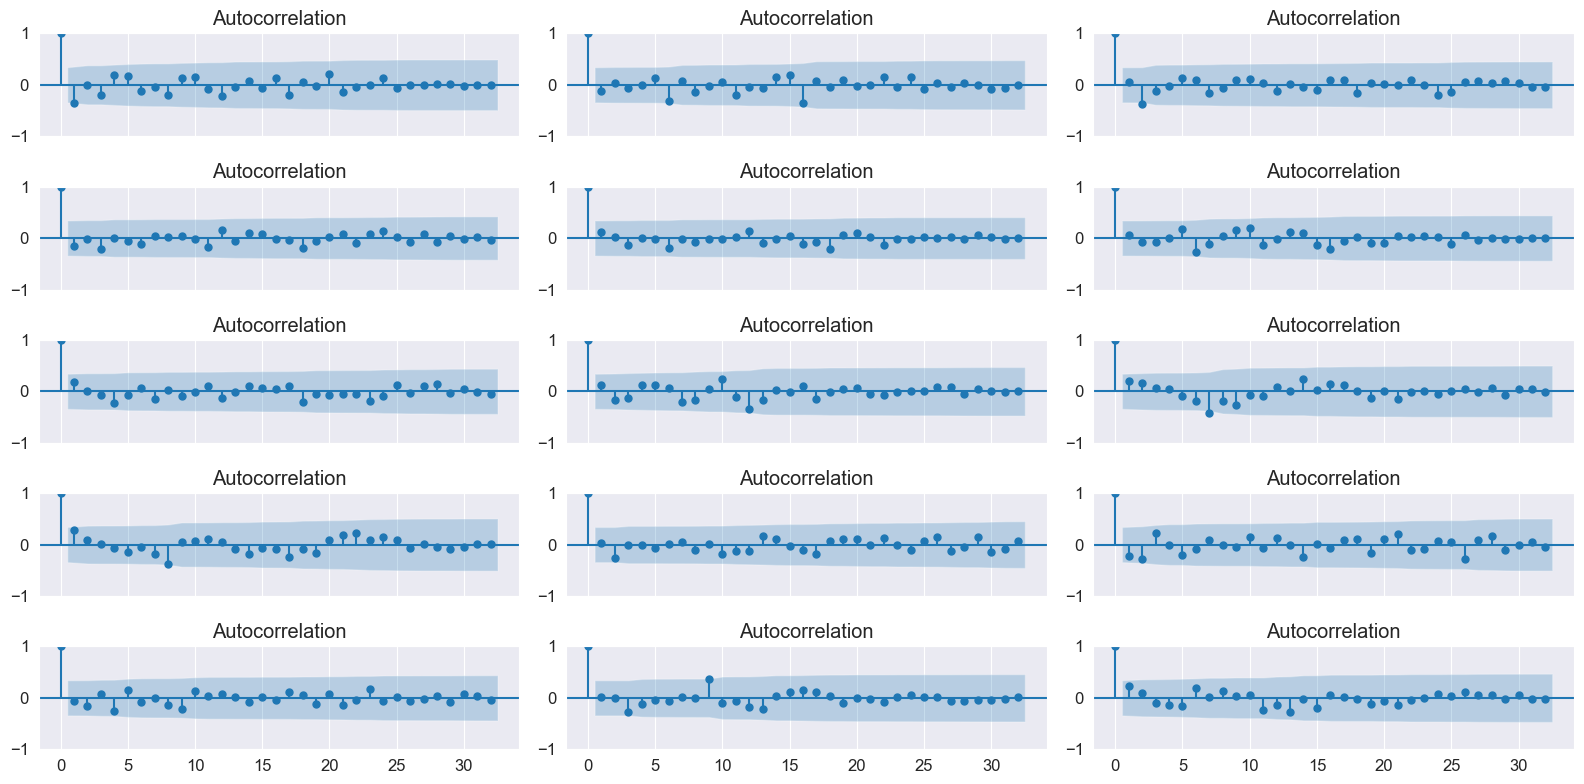

In [280]:
#Построим 15 графиков автокорреляции для каждого города и каждого типа погоды по месяцам наблюдения
fig, axes = plt.subplots(5, 3, sharex=True, figsize=(16,8))
df = df_total.copy()
df = df

df_res = df[(df['place'] == 'Врата Балдура') &
            (df['product'] == 'Эстус')].resample('M', on='date').sum()[['hot', 'snow', 'rain']]
plot_acf(ax=axes[0,0], x=df_res['hot'], lags=32)
plot_acf(ax=axes[0,1], x=df_res['snow'], lags=32)
plot_acf(ax=axes[0,2], x=df_res['rain'], lags=32)

df_res = df[(df['place'] == 'Анор Лондо') &
            (df['product'] == 'Эстус')].resample('M', on='date').sum()[['hot', 'snow', 'rain']]
plot_acf(ax=axes[1,0], x=df_res['hot'], lags=32)
plot_acf(ax=axes[1,1], x=df_res['snow'], lags=32)
plot_acf(ax=axes[1,2], x=df_res['rain'], lags=32)

df_res = df[(df['place'] == 'Фалькония') &
            (df['product'] == 'Эстус')].resample('M', on='date').sum()[['hot', 'snow', 'rain']]
plot_acf(ax=axes[2,0], x=df_res['hot'], lags=32)
plot_acf(ax=axes[2,1], x=df_res['snow'], lags=32)
plot_acf(ax=axes[2,2], x=df_res['rain'], lags=32)

df_res = df[(df['place'] == 'Кеджистан') &
            (df['product'] == 'Эстус')].resample('M', on='date').sum()[['hot', 'snow', 'rain']]
plot_acf(ax=axes[3,0], x=df_res['hot'], lags=32)
plot_acf(ax=axes[3,1], x=df_res['snow'], lags=32)
plot_acf(ax=axes[3,2], x=df_res['rain'], lags=32)

df_res = df[(df['place'] == 'Нокрон') &
            (df['product'] == 'Эстус')].resample('M', on='date').sum()[['hot', 'snow', 'rain']]
plot_acf(ax=axes[4,0], x=df_res['hot'], lags=32)
plot_acf(ax=axes[4,1], x=df_res['snow'], lags=32)
plot_acf(ax=axes[4,2], x=df_res['rain'], lags=32)

fig.tight_layout()
pass

Достаточно сильная автокорреляция по месяцам также отсутствует. Это значит, что в данных городах с достаточной точностью предсказать погоду даже на маленьком интервале невозможно, а значит и использовать в качестве признака для будущей модели не представляется возможным.

## Построение предиктора

В результате многочисленных экспериментов наиболее эффективной с точки зрения точности прогноза и времени обучения и оказалась модель, cостоящая из двух CatBoostRegressor в обертке ForecasterAutoreg для автоматического вычисления лагов.
1. Первый регрессор выявляет сезонность, так как сезонные изменения `amount` не соответствуют естественной смене сезонов по годам/месяцам и т.д.
Необходимо обучить модель понимать, сколько дней составляет сезон в нашем мире.
2. Второй регрессор получает информацию о сезонности от первого и дообучается на основе экзогенных признаков, таких как максимальная цена конкурентов, средняя, и т.д.

Покажем расчет на примере Эстуса во Вратах Балдура.

In [281]:
place = 'Врата Балдура'
product = 'Эстус'

days = 90

df = df_total[(df_total['place'] == place) & (df_total['product'] == product)].copy()

In [282]:
#Проведем сплит выборки на обучающую и тестовую
df_train, df_test = ts_train_test_split(df, 'date', days)

#Создадим индексы в формате DateTimeIndex на основе дат.
#Это необходимо для автоматического расчета лагов с помощью ForecasterAutoreg.
df_train = preproc(df_train, 'date')
df_test = preproc(df_test, 'date')

#Целевая переменная
target = 'amount'

#Иницилизируем объект forecaster, в качестве регрессора передадим CatBoostRegressor
forecaster = ForecasterAutoreg(regressor=CatBoostRegressor(random_state =RANDOM_STATE,
                                                           silent=True,
                                                           allow_writing_files=False,
                                                           has_time=True),
                               lags=1
                               # Инициилизируем единицей, но далее
                               # будем менять во время grid search
                               )

#Сетка параметров регрессора
#Зададим относительно большое значение регуляризации для уменьшения влияния не сезонных лагов.
param_grid = {'n_estimators': [1000],
              'max_depth': [5],
              'l2_leaf_reg': [5]}

#Сетка лагов, например [365]   ->  1, 2, 3, ... , 365
#                      [[365]] ->  365
lags_grid = [365]

#grid search на основе заданных параметров, передаем туда
# - объект forecaster
# - целевую переменную обучающей выборке
# - сетку параметров и лагов
# - количество шагов для прогноза вперед
# - метрику
# grid_search_forecaster автоматически выполняет кросс-валидацию для временных рядов
# начальный размер обучающей выборки задается в initial_train_size
results_grid = grid_search_forecaster(forecaster  = forecaster,
                                      y           = df_train[target],
                                      param_grid  = param_grid,
                                      lags_grid   = lags_grid,
                                      steps       = 90,
                                      refit       = True,
                                      metric      = 'mean_squared_error',
                                      initial_train_size = int(len(df_train)*0.5),
                                      fixed_train_size   = False,
                                      return_best = True,
                                      verbose     = False)

Number of models compared: 1.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

В результате на выходе получаем авторегрессор, обученный на предсказание ряда без внешних признаков.
Посмотрим на важность признаков, сделаем предсказание и рассчитаем метрики.

In [283]:
#Класс ForecasterAutoreg обладает методом get_feature_importances,
#который позволяет вывести наиболее важные признаки
imps = forecaster.get_feature_importances()
imps.sort_values(by='importance', ascending=False, inplace=True)

lags_list = []
for lag in imps.head(10).feature.values:
    lags_list.append(int(lag.split('_')[1]))
print(lags_list)

[226, 251, 230, 10, 239, 237, 246, 247, 248, 264]


In [284]:
#Прогноз делается с помощью predict с указанием кол-ва шагов
forecast = forecaster.predict(steps=90)
#Выведем MAPE и RMSE
print(f"MAPE: {mean_absolute_percentage_error(forecast, df_test['amount']):.2}")
print(f"RMSE: {np.sqrt(mean_squared_error(forecast, df_test['amount'])):.3}")

MAPE: 0.22
RMSE: 6.57


Text(0, 0.5, 'Объем продаж')

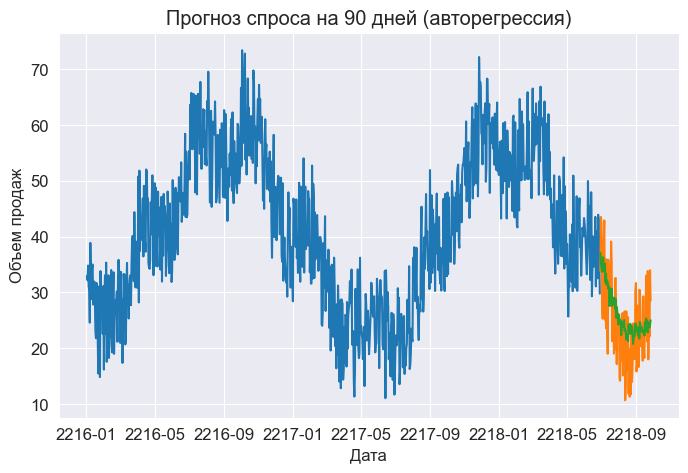

In [285]:
sns.lineplot(x=df_train.index,
             y=df_train['amount'])
sns.lineplot(x=df_test.index,
             y=df_test['amount'])
sns.lineplot(x=df_test.index,
             y=forecast)
plt.title('Прогноз спроса на 90 дней (авторегрессия)')
plt.xlabel('Дата')
plt.ylabel('Объем продаж')

Как видно из графика, модель в целом неплохо выучила сезонность изменения `amount`. Авторегрессионная модель показывает уже неплохие метрики, MAPE = 22 %, RMSE = 6.57.
Обучим еще один регрессор, уже с внешними признаками, в качестве лагов передадим наиболее важные, найденные на предыдущей итерации.
В качестве признаков выберем

+ `rel_max_price_comp**2`
+ `rel_min_price_comp**2`
+ `rel_mean_price_comp**2`

Эти признаки эффективно позволяют модели выявить нелинейности в зависимости спроса от разницы цен конкурентов с нашей ценой на товар.

In [286]:
#Проведем сплит выборки на обучающую и тестовую
df_train, df_test = ts_train_test_split(df, 'date', days)

#Создадим индексы в формате DateTimeIndex на основе дат.
#Это необходимо для автоматического расчета лагов с помощью ForecasterAutoreg
df_train = preproc(df_train, 'date')
df_test = preproc(df_test, 'date')

#Целевая переменная
target = 'amount'

#Иницилизируем объект forecaster, в качестве регрессора передадим CatBoostRegressor
forecaster = ForecasterAutoreg(regressor=CatBoostRegressor(random_state=RANDOM_STATE,
                                                           silent=True,
                                                           allow_writing_files=False,
                                                           has_time=True),
                               lags=lags_list)
#Сетка параметров регрессора
param_grid = {'n_estimators': [50, 100, 150, 200, 500, 1000],
              'max_depth': [1, 2, 3, 5, 7, 10],
              'l2_leaf_reg': [0]}

#Создадим новые признаки на выборке
df_train = create_exog(df_train)

#Список экзогенных признаков для модели
exog = ['rel_max_price_comp**2',
        'rel_min_price_comp**2',
        'rel_mean_price_comp**2']

#grid search на основе заданных параметров, передаем туда
# - объект forecaster
# - целевую переменную обучающей выборке
# - экзогенные признаки
# - сетку параметров
# - количество шагов для прогноза вперед
# - метрику
# grid_search_forecaster автоматически выполняет кросс-валидацию для временных рядов
# начальный размер обучающей выборки задается в initial_train_size
results_grid = grid_search_forecaster(forecaster  =forecaster,
                                      y           =df_train[target],
                                      exog        =df_train[exog],
                                      param_grid  = param_grid,
                                      steps       = 90,
                                      refit       = True,
                                      metric      = 'mean_squared_error',
                                      initial_train_size = int(len(df_train)*0.5),
                                      fixed_train_size   = False,
                                      return_best = True,
                                      verbose     = False)

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [226 251 230  10 239 237 246 247 248 264] 
  Parameters: {'l2_leaf_reg': 0, 'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 46.64782115526198



In [287]:
#Класс ForecasterAutoreg обладает методом get_feature_importances,
#который позволяет вывести наиболее важные признаки
imps = forecaster.get_feature_importances()
imps.sort_values(by='importance', ascending=False, inplace=True)
imps.head(15)

,feature,importance
1,lag_251,11.185781
3,lag_10,11.142727
12,rel_mean_price_comp**2,9.067846
7,lag_247,8.793187
8,lag_248,8.702969
4,lag_239,8.599524
9,lag_264,7.840250
6,lag_246,7.791040
2,lag_230,7.629409
11,rel_min_price_comp**2,5.602630


In [288]:
#Сгенерируем признаки на тестовой выборке
df_test = create_exog(df_test)

#Прогноз делается с помощью predict с указанием кол-ва шагов
forecast = forecaster.predict(steps=90, exog=df_test[exog])

#Выведем MAPE и RMSE
print(f"MAPE: {mean_absolute_percentage_error(forecast, df_test['amount']):.2}")
print(f"RMSE: {np.sqrt(mean_squared_error(forecast, df_test['amount'])):.3}")

MAPE: 0.22
RMSE: 6.41


MAPE не изменилось, RMSE немного уменьшилось, но одним из первых по важности признаков стал экзогенный, и теперь модель так же обладает знанием о зависимости разницы между ценами конкурентов и нашей.

Text(0, 0.5, 'Объем продаж')

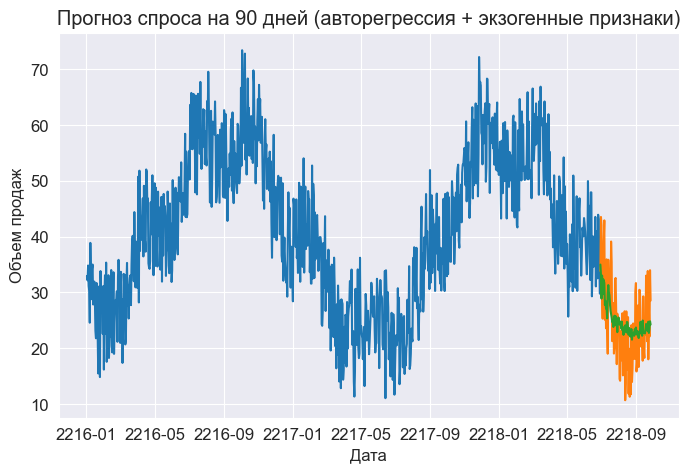

In [289]:
sns.lineplot(x=df_train.index,
             y=df_train['amount'])
sns.lineplot(x=df_test.index,
             y=df_test['amount'])
sns.lineplot(x=df_test.index,
             y=forecast)
plt.title('Прогноз спроса на 90 дней (авторегрессия + экзогенные признаки)')
plt.xlabel('Дата')
plt.ylabel('Объем продаж')

Модель чуть больше адаптировалась, но мы все так также в основном предсказываем среднее значение `amount` с сезонными изменениями.

## Формирование закона изменения цены

Следующим шагом является выбор цены для максимизации прибыли. Решим эту задачу с помощью методов численной оптимизации.
+ Введем критерий успешности цены - максимизация прибыли, но при этом с ограничениями:
  1. Цена не должна превышать максимум цен конкурентов более чем на 20%.
  2. Цена на товар должна держаться больше, чем 3 дня. Значит минимальный период постоянства цены - 4 дня. Будем оптимизировать с такой периодичностью.
  Это может быть не лучшая абсолютно стратегия, но значительно упрощает ограничения, расчеты и время поиска оптимума.
  3. Цена на товар не должна изменяться более чем на 1 единицу.
+ В критерии на каждой итерации будем проводить predict объема продаж на основе нашей новой цены и рассчитывать прибыль.
+ Критерий передадим в функцию minimize из SciPy, и подобрав лучший метод расчета, найдем оптимум.

При этом эксперименты показали, что за начальное приближение эффективнее брать среднюю цену конкурентов, чем baseline в виде нашей последней цены, но при этом не всегда гарантируется нахождение минимума. Будем брать baseline.

In [290]:
#Из-за издержек унификации алгоритма для упрощения предскажем на 88 дня вперед, поскольку ближайшие к 90 числа, которые делятся нацело это 88 и 92.
#Если мы предскажем сейчас на 92 дня вперед, то нужно будет менять train/test cплит, поскольку в тесте у нас 90 дней
#Во время инференса мы сможем предсказывать на 92 дня и брать первые 90 значений, поскольку теста у нас не будет

#Прогноза на 88 дней будет достаточно для оценки эффективности алгоритма
days = 88

#Берем последнюю цену известного нам периода
last_price = df_train['selling_price'].tail(1)

#За начальное приближение берем baseline
four_days_prices = np.array(last_price).repeat(22)

# или можно среднюю цену конкурентов
# four_days_prices = df_test.head(88)['mean_price_comp'][::4]

#Напишем функцию критерий оптимизации, которая получает на вход цены-кандидаты от оптимизатора и другие данные, необходимые для расчета
def criteria(four_days_prices, *args):
    #Вытащим аргументы, args[0] - датафрейм на основе которого считаются экзогенные признаки
    #                   args[1] - последняя цена (baseline)

    df = args[0].copy()
    last_price = args[1]

    #От информации о цене раз в 4 дня переходим к 4 повторяющимся ценам каждые 4 дня
    df['selling_price'] = four_days_prices.repeat(4)

    #Первое ограничение - изменение цены больше чем на 1 за раз
    if np.abs(np.diff(four_days_prices)).max() > 1:
        pen1 = 100_000 * np.abs(four_days_prices).max()
    else:
        pen1 = 0

    #Второе ограничение - если первая цена предсказания отличается от последней цены наблюдения больше чем на 1
    if np.abs(four_days_prices[0] - last_price.values)[0] > 0.001:
        pen2 = 100_000_0 * np.abs(four_days_prices[0] - last_price.values)[0]
    else:
        pen2 = 0

    #Создаем экзогенные признаки для прогноза
    df = create_exog(df)

    #Предсказываем спрос с нашей ценой-кандидатом
    forecast = forecaster.predict(steps=88, exog=df[exog])

    #Считаем прибыль
    res = profit(price=df['selling_price'],
                 amount=forecast,
                 cost=df['cost'])

    #Выводим цену на каждой итерации
    print(res.round(2))
    return -res + pen1 + pen2

#Создаем верхнюю и нижние границы на основе максимальной цены конкурентов (не больше 120% от максимальной, не меньше 0)
ub_bound = df_test['max_price_comp'].apply(lambda x: x*1.2).tail(days)[::4]
lb_bound = df_test['max_price_comp'].apply(lambda x: x*0).tail(days)[::4]

#Инициализируем экземпляр класса Bounds для установки границ
bounds = Bounds(ub=ub_bound , lb=lb_bound)

#Минимизация критерия (максимизация прибыли)
#Начальные значения - baseline
res = minimize(fun=criteria,
               x0=four_days_prices,
               options={'maxiter': 1000, 'disp': True,
                        'verbose': True
                        },
               args=(df_test.head(days), last_price),
               method='Nelder-Mead',
               tol=1,
               bounds=bounds)

19584.53
19688.68
19686.32
19673.74
19665.48
19659.6
19655.68
19649.29
19631.72
19620.52
19603.02
19582.8
19569.78
19574.7
19576.03
19570.81
19551.53
19538.62
19541.89
19551.37
19537.69
19552.52
19538.52
19485.66
19587.89
19502.39
19587.47
19481.15
19564.18
19487.06
19560.33
19496.26
19558.57
19497.31
19538.35
19535.7
19538.51
19532.86
19535.88
19533.42
19535.83
19533.47
19535.81
19533.49
19535.79
19681.72
19669.7
19661.73
19657.55
19648.87
19641.21
19625.52
19604.32
19638.71
19582.56
19575.94
19571.43
19570.4
19558.51
19581.78
19559.17
19561.47
19550.92
19548.34
19582.47
19554.97
19575.3
19521.14
19580.54
19530.72
19573.68
19535.36
19593.69
19586.26
19546.46
19582.64
19581.07
19583.61
19624.1
19613.39
19615.24
19630.34
19623.81
19547.99
19618.37
19614.3
19594.28
19622.36
19587.77
19599.61
19598.51
19532.17
19632.89
19605.59
19533.37
19647.09
19618.85
19604.39
19596.74
19563.66
19680.59
19668.89
19661.37
19649.19
19641.19
19652.06
19633.07
19659.98
19652.92
19655.53
19616.32
19640.25
1

Рекомендуемый закон изменения цены

Text(0, 0.5, 'Цена')

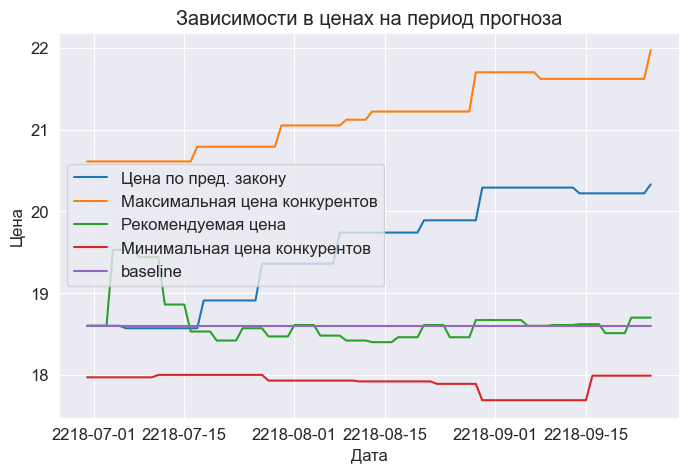

In [291]:
sns.lineplot(x=df_test.head(days).index,
             y=df_test.head(days)['selling_price'],
             label = 'Цена по пред. закону')
sns.lineplot(x=df_test.head(days).index,
             y=df_test.head(days)['max_price_comp'],
             label = 'Максимальная цена конкурентов')
sns.lineplot(x=df_test.head(days).index,
             y=res.x.repeat(4).round(2),
             label = 'Рекомендуемая цена')
sns.lineplot(x=df_test.head(days).index,
             y=df_test.head(days)['min_price_comp'],
             label = 'Минимальная цена конкурентов')
sns.lineplot(x=df_test.head(days).index,
             y=last_price.repeat(days).round(2),
             label = 'baseline')
plt.legend()
plt.title('Зависимости в ценах на период прогноза')
plt.xlabel('Дата')
plt.ylabel('Цена')

Цена, которую рекомендует наш алгоритм, на графике представлена зеленым.

# Инференс

Выполним всю последовательность действий до рекомендации цены на примере Эстуса во Вратах Балдура, модель будем обучать на всем объеме данных. Предсказывать будем на заданный промежуток - 90 дней.

In [292]:
place = 'Врата Балдура'
product = 'Эстус'
days = 92 #Два лишних дня отрежем в конце

df_train = df_total[(df_total['place'] == place) & (df_total['product'] == product)]
df_train = preproc(df_train, label='date')

df_train

,place,product,amount,selling_price,price_comp_1,price_comp_2,price_comp_3,price_comp_4,cost,hot,...,rel_mean_price_comp,rel_max_price_comp**2,rel_min_price_comp**2,rel_mean_price_comp**2,all_max_price,all_min_price,all_mean_price,rel_all_max_price,rel_all_min_price,rel_all_mean_price
date,,,,,,,,,,,,,,,,,,,,,
2216-01-02,Врата Балдура,Эстус,32.919055,7.80,7.81,8.29,8.28,8.45,4.8900,0,...,-0.049650,0.005917,0.000002,0.002465,8.45,7.80,8.126,-0.076923,0.000000,-0.040118
2216-01-03,Врата Балдура,Эстус,32.177640,7.80,7.81,8.29,8.28,8.45,4.6825,0,...,-0.049650,0.005917,0.000002,0.002465,8.45,7.80,8.126,-0.076923,0.000000,-0.040118
2216-01-04,Врата Балдура,Эстус,34.826636,7.80,7.81,8.29,8.28,8.45,4.4750,0,...,-0.049650,0.005917,0.000002,0.002465,8.45,7.80,8.126,-0.076923,0.000000,-0.040118
2216-01-05,Врата Балдура,Эстус,31.179459,7.80,7.81,8.29,8.28,8.45,4.2675,1,...,-0.049650,0.005917,0.000002,0.002465,8.45,7.80,8.126,-0.076923,0.000000,-0.040118
2216-01-06,Врата Балдура,Эстус,30.279028,7.80,7.81,8.29,8.28,8.45,4.0600,0,...,-0.049650,0.005917,0.000002,0.002465,8.45,7.80,8.126,-0.076923,0.000000,-0.040118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218-09-23,Врата Балдура,Эстус,18.021374,20.22,19.83,20.80,21.62,17.99,9.6200,0,...,0.007976,0.004193,0.015366,0.000064,21.62,17.99,20.092,-0.064755,0.123958,0.006371
2218-09-24,Врата Балдура,Эстус,26.894850,20.22,19.83,20.80,21.62,17.99,9.1800,0,...,0.007976,0.004193,0.015366,0.000064,21.62,17.99,20.092,-0.064755,0.123958,0.006371
2218-09-25,Врата Балдура,Эстус,22.086726,20.33,19.83,20.80,21.97,17.99,8.7400,0,...,0.009058,0.005572,0.016919,0.000082,21.97,17.99,20.184,-0.074647,0.130072,0.007233


prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


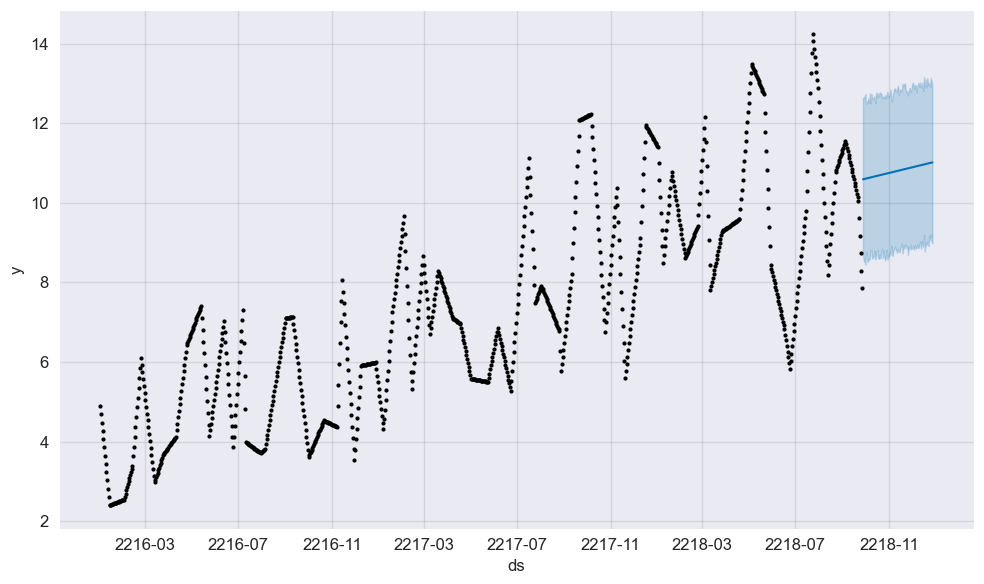

In [293]:
#Прогнозируем затраты как тренд
target = 'cost'

df_prophet_train = df_train.reset_index()[['date', target]]
df_prophet_train.columns=['ds', 'y']
df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])

m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False)
m.fit(df_prophet_train)
future = m.make_future_dataframe(periods=days,
                                 include_history=False)
forecast_prophet = m.predict(future)
fig = m.plot(forecast_prophet)

In [294]:
#Создаем таблицу инференса с предсказаниями и прогнозами
#и добавляем в нее затраты
df_inference = forecast_prophet[['ds', 'yhat']]
df_inference.columns = ['date', 'cost']
df_inference.head(5)

,date,cost
0,2218-09-28,10.595096
1,2218-09-29,10.599769
2,2218-09-30,10.604441
3,2218-10-01,10.609113
4,2218-10-02,10.613785


prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


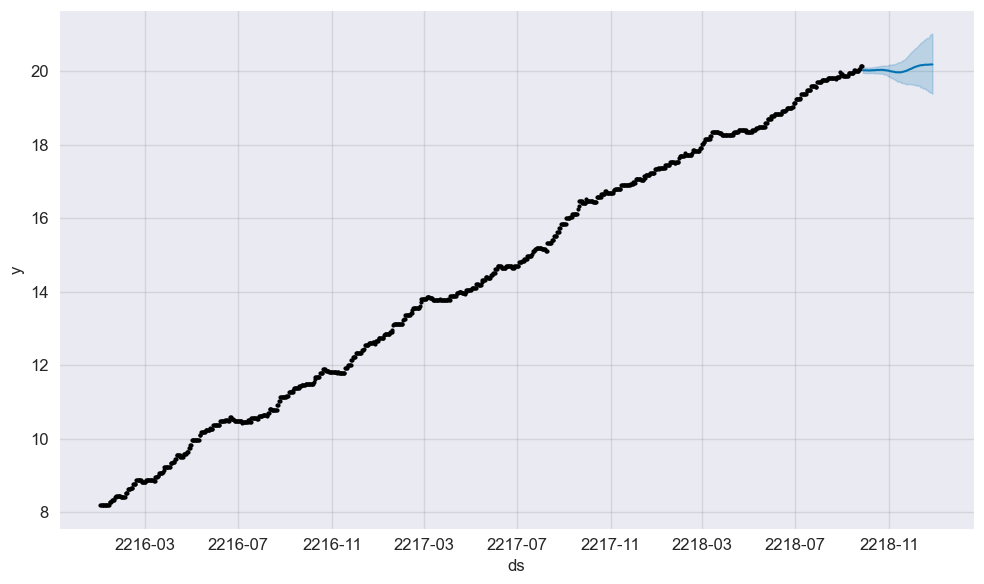

In [295]:
#Прогнозируем среднюю цену конкурентов
target = 'mean_price_comp'

df_prophet_train = df_train.reset_index()[['date',target]]
df_prophet_train.columns=['ds', 'y']
df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])

m = Prophet()
m.fit(df_prophet_train)

future = m.make_future_dataframe(periods=days,
                                 include_history=False)
forecast_prophet = m.predict(future)
fig = m.plot(forecast_prophet)

In [296]:
#В качестве прогноза на инференс возьмем непосредственно сам прогноз
df_inference['mean_price_comp'] = forecast_prophet['yhat']
df_inference.head(5)

,date,cost,mean_price_comp
0,2218-09-28,10.595096,20.023119
1,2218-09-29,10.599769,20.021578
2,2218-09-30,10.604441,20.022735
3,2218-10-01,10.609113,20.022606
4,2218-10-02,10.613785,20.020565


prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


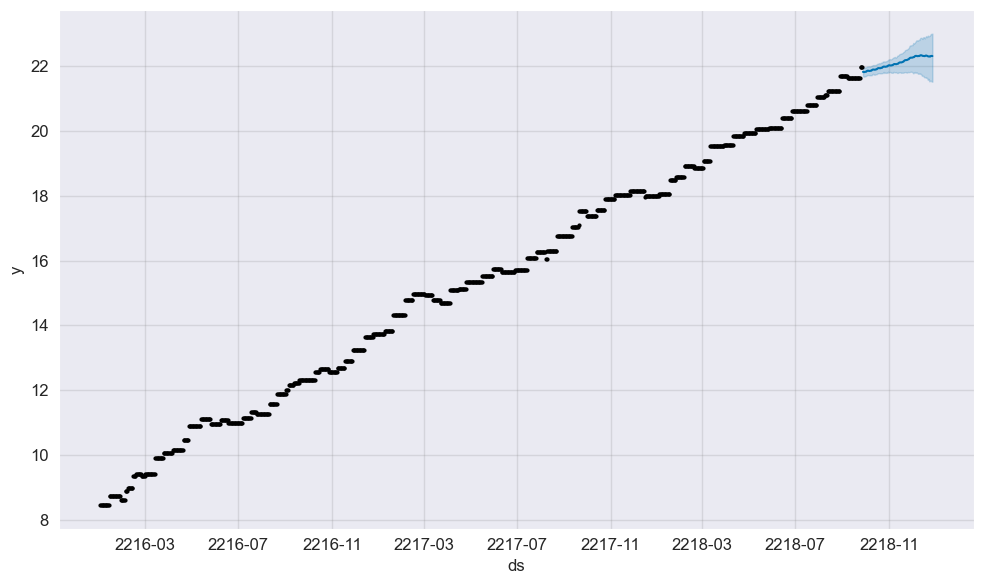

In [297]:
#Прогнозируем максимальную цену конкурентов
target = 'max_price_comp'

df_prophet_train = df_train.reset_index()[['date',target]]
df_prophet_train.columns=['ds', 'y']
df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])

m = Prophet()
m.fit(df_prophet_train)

future = m.make_future_dataframe(periods=days,
                                 include_history=False)
forecast_prophet = m.predict(future)
fig = m.plot(forecast_prophet)

In [298]:
#В качестве прогноза на инференс возьмем верхний доверительный интервал
df_inference['max_price_comp'] = forecast_prophet['yhat_upper']
df_inference.head(5)

,date,cost,mean_price_comp,max_price_comp
0,2218-09-28,10.595096,20.023119,21.957937
1,2218-09-29,10.599769,20.021578,21.949450
2,2218-09-30,10.604441,20.022735,21.946925
3,2218-10-01,10.609113,20.022606,21.967159
4,2218-10-02,10.613785,20.020565,21.959946


prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


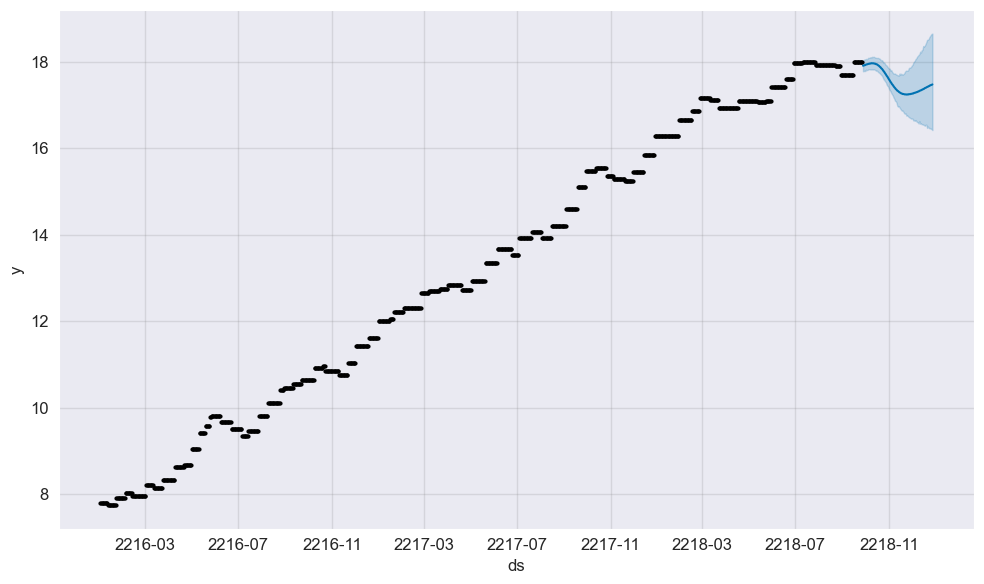

In [299]:
#Прогнозируем минимальную цену конкурентов
target = 'min_price_comp'

df_prophet_train = df_train.reset_index()[['date',target]]
df_prophet_train.columns=['ds', 'y']
df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])

m = Prophet()
m.fit(df_prophet_train)

future = m.make_future_dataframe(periods=days,
                                 include_history=False)
forecast_prophet = m.predict(future)
fig = m.plot(forecast_prophet)

In [300]:
#В качестве прогноза на инференс возьмем нижний доверительный интервал
df_inference['min_price_comp'] = forecast_prophet['yhat_lower']

#Проведем обработку индексов для дальнейшей регрессии
df_inference = preproc(df_inference, 'date')
df_inference.head(5)

,cost,mean_price_comp,max_price_comp,min_price_comp
date,,,,
2218-09-28,10.595096,20.023119,21.957937,17.775332
2218-09-29,10.599769,20.021578,21.949450,17.778327
2218-09-30,10.604441,20.022735,21.946925,17.789527
2218-10-01,10.609113,20.022606,21.967159,17.779168
2218-10-02,10.613785,20.020565,21.959946,17.812037


In [301]:
#Обучаем авторегрессионную модель
forecaster = ForecasterAutoreg(regressor=CatBoostRegressor(random_state=RANDOM_STATE,
                                                           silent=True,
                                                           allow_writing_files=False,
                                                           has_time=True),
                               lags=1)
target = 'amount'
param_grid = {'n_estimators': [500, 750, 1000],
              'max_depth': [5],
              'l2_leaf_reg': [5]}
lags_grid = [365]
results_grid = grid_search_forecaster(forecaster  = forecaster,
                                      y           = df_train[target],
                                      param_grid  = param_grid,
                                      lags_grid   = lags_grid,
                                      steps       = days,
                                      refit       = True,
                                      metric      = 'mean_squared_error',
                                      initial_train_size = int(len(df_train)*0.5),
                                      fixed_train_size   = False,
                                      return_best = True,
                                      verbose     = False)

Number of models compared: 3.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

In [302]:
#Получаем самые важные лаги
imps = forecaster.get_feature_importances()
imps.sort_values(by='importance', ascending=False, inplace=True)
lags_list = []
for lag in imps.head(15).feature.values:
    lags_list.append(int(lag.split('_')[1]))
print(lags_list)

[248, 241, 1, 10, 256, 232, 237, 246, 264, 266, 13, 215, 2, 250, 261]


In [303]:
#Делаем предсказание
forecast = forecaster.predict(steps=days)

Text(0, 0.5, 'Объем продаж')

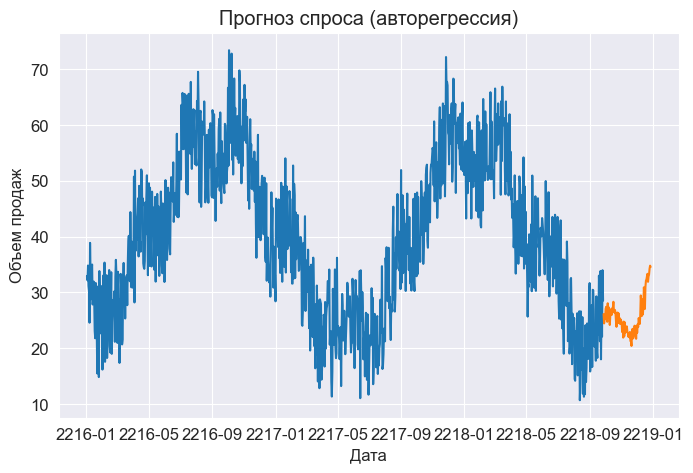

In [304]:
#Визуализируем предсказание
sns.lineplot(x=df_train.index,
             y=df_train['amount'])
sns.lineplot(x=df_inference.index,
             y=forecast.values)
plt.title('Прогноз спроса (авторегрессия)')
plt.xlabel('Дата')
plt.ylabel('Объем продаж')

In [305]:
#Обучим предсказатель с экзогенными признаками
forecaster = ForecasterAutoreg(regressor=CatBoostRegressor(random_state=RANDOM_STATE,
                                                           silent=True,
                                                           allow_writing_files=False,
                                                           has_time=True),
                               lags=lags_list)

target = 'amount'

param_grid = {'n_estimators': [50, 100, 150, 200, 500, 1000],
              'max_depth': [1, 2, 3, 5, 7, 10],
              'l2_leaf_reg': [0]}

exog = ['rel_max_price_comp**2',
        'rel_min_price_comp**2',
        'rel_mean_price_comp**2']

df_train = create_exog(df_train)
results_grid = grid_search_forecaster(forecaster  = forecaster,
                                      y           = df_train[target],
                                      exog        = df_train[exog],
                                      param_grid  = param_grid,
                                      steps       = days,
                                      refit       = True,
                                      metric      = 'mean_squared_error',
                                      initial_train_size = int(len(df_train)*0.5),
                                      fixed_train_size   = False,
                                      return_best = True,
                                      verbose     = False)

Number of models compared: 36.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [248 241   1  10 256 232 237 246 264 266  13 215   2 250 261] 
  Parameters: {'l2_leaf_reg': 0, 'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 42.47863755203101



In [306]:
#Функция для генерации экзогенных признаков для инференса,
#в которой нужны только прогнозы min/max/mean значения
def create_exog_inference(df):
    df = df.copy()

    df['rel_max_price_comp'] = (df['selling_price'] - df['max_price_comp']) / df['max_price_comp']
    df['rel_min_price_comp'] = (df['selling_price'] - df['min_price_comp']) / df['min_price_comp']
    df['rel_mean_price_comp'] = (df['selling_price'] - df['mean_price_comp']) / df['mean_price_comp']

    df['rel_max_price_comp**2'] =   df['rel_max_price_comp'] ** 2
    df['rel_min_price_comp**2'] =   df['rel_min_price_comp'] ** 2
    df['rel_mean_price_comp**2'] =  df['rel_mean_price_comp'] **2

    return df

In [307]:
#Найдем оптимальную рекомендуемую цену на предсказываемый диапазон дат

last_price = df_train['selling_price'].tail(1)
four_days_prices = df_inference['mean_price_comp'][::4]

def criteria(four_days_prices, *args):
    df = args[0].copy()
    last_price = args[1]

    df['selling_price'] = four_days_prices.repeat(4)

    if np.abs(np.diff(four_days_prices)).max() > 1:
        pen1 = 100_000 * np.abs(four_days_prices).max()
    else:
        pen1 = 0

    if np.abs(four_days_prices[0] - last_price.values)[0] > 0.001:
        pen2 = 100_000_0 * np.abs(four_days_prices[0] - last_price.values)[0]
    else:
        pen2 = 0

    df = create_exog_inference(df)

    forecast = forecaster.predict(steps=90, exog=df[exog])

    res = profit(price=df['selling_price'],
                 amount=forecast,
                 cost=df['cost'])
    # print(res.round(2))

    return -res + pen1 + pen2

ub_bound = df_inference['max_price_comp'].apply(lambda x: x*1.2).tail(days)[::4]
lb_bound = df_inference['max_price_comp'].apply(lambda x: x*0).tail(days)[::4]

bounds = Bounds(ub=ub_bound , lb=lb_bound)

res = minimize(fun=criteria,
               x0=four_days_prices,
               options={'maxiter': 5000, 'disp': True,
                        'verbose': True,
                        },
               args=(df_inference, last_price),
               method='Nelder-Mead',
               tol=1,
               bounds=bounds)

Optimization terminated successfully.
         Current function value: -21436.343308
         Iterations: 361
         Function evaluations: 631


In [308]:
#Посмотрим на наше предсказание
df_inference['selling_price'] = res.x.repeat(4).round(2)
df_inference.head()

,cost,mean_price_comp,max_price_comp,min_price_comp,selling_price
date,,,,,
2218-09-28,10.595096,20.023119,21.957937,17.775332,20.33
2218-09-29,10.599769,20.021578,21.949450,17.778327,20.33
2218-09-30,10.604441,20.022735,21.946925,17.789527,20.33
2218-10-01,10.609113,20.022606,21.967159,17.779168,20.33
2218-10-02,10.613785,20.020565,21.959946,17.812037,20.02


In [309]:
#Проверим макс шаг изменения цены в 1
(df_inference['selling_price'].diff().abs() > 1).sum()

0

Text(0, 0.5, 'Цена')

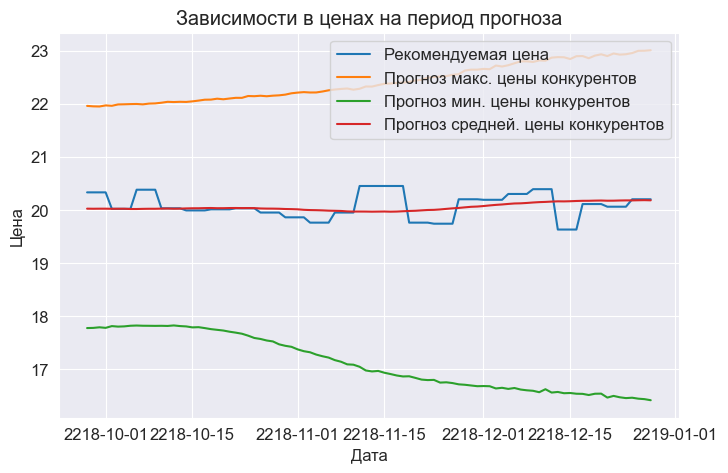

In [310]:
#Посмотрим на графики цен
sns.lineplot(x=df_inference.index,
             y=df_inference['selling_price'],
             label='Рекомендуемая цена')
sns.lineplot(x=df_inference.index,
             y=df_inference['max_price_comp'],
             label='Прогноз макс. цены конкурентов')
sns.lineplot(x=df_inference.index,
             y=df_inference['min_price_comp'],
             label='Прогноз мин. цены конкурентов')
sns.lineplot(x=df_inference.index,
             y=df_inference['mean_price_comp'],
             label='Прогноз средней. цены конкурентов')
plt.legend()
plt.title('Зависимости в ценах на период прогноза')
plt.xlabel('Дата')
plt.ylabel('Цена')

In [311]:
#Уберем 2 лишних дня из предсказания
df_inference = df_inference[:-2:]

In [312]:
df_inference.head(5)

,cost,mean_price_comp,max_price_comp,min_price_comp,selling_price
date,,,,,
2218-09-28,10.595096,20.023119,21.957937,17.775332,20.33
2218-09-29,10.599769,20.021578,21.949450,17.778327,20.33
2218-09-30,10.604441,20.022735,21.946925,17.789527,20.33
2218-10-01,10.609113,20.022606,21.967159,17.779168,20.33
2218-10-02,10.613785,20.020565,21.959946,17.812037,20.02


# Предсказание

В конце нотбука в закомментированой секции проводится расчет предсказаний цен на требуемый период во всех городах на все товары.
За первое приближение берется baseline - последняя цена на этот товар.
Расчет занял несколько часов, собрав оттуда данные получим:

In [318]:
ans = pd.read_parquet('df_answer.parquet')
ans

,day_number,product,place,price
0,1,Целебные травы,Анор Лондо,13.63
1,2,Целебные травы,Анор Лондо,13.63
2,3,Целебные травы,Анор Лондо,13.63
3,4,Целебные травы,Анор Лондо,13.63
4,5,Целебные травы,Анор Лондо,12.78
...,...,...,...,...
1345,86,Эстус,Фалькония,9.30
1346,87,Эстус,Фалькония,9.30
1347,88,Эстус,Фалькония,9.30
1348,89,Эстус,Фалькония,9.26


In [314]:
# Файл profit.cvs собран вручную из вывода расчетов по всем товарам и магазинам
df_profit = pd.read_csv('profit.csv')
df_profit

,product,place,profit_base,profit_rec
0,Целебные травы,Анор Лондо,19329,20298
1,Эльфийская пыльца,Анор Лондо,31169,33337
2,Эстус,Анор Лондо,18004,21607
3,Целебные травы,Врата Балдура,11541,12592
4,Эльфийская пыльца,Врата Балдура,16225,17208
5,Эстус,Врата Балдура,22015,24353
6,Целебные травы,Кеджистан,27208,31759
7,Эльфийская пыльца,Кеджистан,46433,47629
8,Эстус,Кеджистан,48377,50813
9,Целебные травы,Нокрон,16382,17647


In [315]:
print(f"Изменяя цену относительно baseline (последняя цена) мы бы заработали "
      f"{df_profit['profit_rec'].sum() - df_profit['profit_base'].sum()} зол.")

Изменяя цену относительно baseline (последняя цена) мы бы заработали 28264 зол.


In [316]:
print(f"Или на {100 * (df_profit['profit_rec'].sum() - df_profit['profit_base'].sum()) / (df_profit['profit_base'].sum()):.2f} % больше")

Или на 7.75 % больше


## Наша потенциальная прибыль с таким законом ценообразования сравнима с открытием еще одного магазина!

In [317]:
# df_answer = pd.DataFrame(columns=['day_number', 'product', 'place', 'price'])
# df_answer.to_parquet('df_answer.parquet')
#
#
# places = ['Анор Лондо', 'Врата Балдура', 'Фалькония', 'Кеджистан', 'Нокрон']
# places.sort()
#
# products = ['Эстус', 'Эльфийская пыльца', 'Целебные травы']
# products.sort()
# days = 92
#
# for place in places:
#     for product in products:
#         print(place, product, 'STARTED')
#
#         df_train = df_total[(df_total['place'] == place) & (df_total['product'] == product)].copy()
#
#         #Прогнозируем затраты как тренд
#         target = 'cost'
#
#         df_prophet_train = df_train.reset_index()[['date', target]]
#         df_prophet_train.columns=['ds', 'y']
#         df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])
#
#         m = Prophet(yearly_seasonality=False,
#                     weekly_seasonality=False)
#         m.fit(df_prophet_train)
#         future = m.make_future_dataframe(periods=days,
#                                          include_history=False)
#         forecast_prophet = m.predict(future)
#
#         #Создаем таблицу инференса с предсказаниями и прогнозами
#         #и добавляем в нее затраты
#         df_inference = forecast_prophet[['ds', 'yhat']]
#         df_inference.columns = ['date', 'cost']
#         df_inference.head(5)
#
#         #Прогнозируем среднюю цену конкурентов
#         target = 'mean_price_comp'
#
#         df_prophet_train = df_train.reset_index()[['date',target]]
#         df_prophet_train.columns=['ds', 'y']
#         df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])
#
#         m = Prophet()
#         m.fit(df_prophet_train)
#
#         future = m.make_future_dataframe(periods=days,
#                                          include_history=False)
#         forecast_prophet = m.predict(future)
#
#         #В качестве прогноза на инференс возьмем непосредственно сам прогноз
#         df_inference['mean_price_comp'] = forecast_prophet['yhat']
#         df_inference.head(5)
#
#         #Прогнозируем максимальную цену конкурентов
#         target = 'max_price_comp'
#
#         df_prophet_train = df_train.reset_index()[['date',target]]
#         df_prophet_train.columns=['ds', 'y']
#         df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])
#
#         m = Prophet()
#         m.fit(df_prophet_train)
#
#         future = m.make_future_dataframe(periods=days,
#                                          include_history=False)
#         forecast_prophet = m.predict(future)
#
#         #В качестве прогноза на инференс возьмем верхний доверительный интервал
#         df_inference['max_price_comp'] = forecast_prophet['yhat_upper']
#         df_inference.head(5)
#
#         #Прогнозируем минимальную цену конкурентов
#         target = 'min_price_comp'
#
#         df_prophet_train = df_train.reset_index()[['date',target]]
#         df_prophet_train.columns=['ds', 'y']
#         df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'])
#
#         m = Prophet()
#         m.fit(df_prophet_train)
#
#         future = m.make_future_dataframe(periods=days,
#                                          include_history=False)
#         forecast_prophet = m.predict(future)
#
#         #В качестве прогноза на инференс возьмем нижний доверительный интервал
#         df_inference['min_price_comp'] = forecast_prophet['yhat_lower']
#
#         #Проведем обработку индексов для дальнейшей регрессии
#         df_inference = preproc(df_inference, 'date')
#         df_inference.head(5)
#
#         df_train = preproc(df_train, 'date')
#         #Обучаем авторегрессионную модель
#         forecaster = ForecasterAutoreg(regressor=CatBoostRegressor(random_state=RANDOM_STATE,
#                                                                    silent=False,
#                                                                    allow_writing_files=False,
#                                                                    has_time=True),
#                                        lags=1)
#         target = 'amount'
#
#         param_grid = {'n_estimators': [1000],
#                       'max_depth': [5],
#                       'l2_leaf_reg': [5]}
#
#         lags_grid = [365]
#         results_grid = grid_search_forecaster(forecaster  = forecaster,
#                                               y           = df_train[target],
#                                               param_grid  = param_grid,
#                                               lags_grid   = lags_grid,
#                                               steps       = days,
#                                               refit       = True,
#                                               metric      = 'mean_squared_error',
#                                               initial_train_size = int(len(df_train)*0.5),
#                                               fixed_train_size   = False,
#                                               return_best = True,
#                                               verbose     = False)
#
#         #Получаем самые важные лаги
#         imps = forecaster.get_feature_importances()
#         imps.sort_values(by='importance', ascending=False, inplace=True)
#         lags_list = []
#         for lag in imps.head(15).feature.values:
#             lags_list.append(int(lag.split('_')[1]))
#
#         forecaster = ForecasterAutoreg(regressor=CatBoostRegressor(random_state=RANDOM_STATE,
#                                                            silent=False,
#                                                            allow_writing_files=False,
#                                                            has_time=True),
#                                lags=lags_list)
#
#         target = 'amount'
#
#         param_grid = {'n_estimators': [100, 200, 500, 1000],
#                       'max_depth': [3, 5, 7, 10],
#                       'l2_leaf_reg': [0]}
#
#         exog = ['rel_max_price_comp**2',
#                 'rel_min_price_comp**2',
#                 'rel_mean_price_comp**2']
#
#         df_train = create_exog(df_train)
#         results_grid = grid_search_forecaster(forecaster  = forecaster,
#                                               y           = df_train[target],
#                                               exog        = df_train[exog],
#                                               param_grid  = param_grid,
#                                               steps       = days,
#                                               refit       = True,
#                                               metric      = 'mean_squared_error',
#                                               initial_train_size = int(len(df_train)*0.5),
#                                               fixed_train_size   = False,
#                                               return_best = True,
#                                               verbose     = False)
#
#
#         last_price = df_train['selling_price'].tail(1)
#         # four_days_prices = df_inference['mean_price_comp'][::4]
#         four_days_prices = np.repeat(last_price, 23)
#
#         def criteria(four_days_prices, *args):
#             df = args[0].copy()
#             last_price = args[1]
#
#             df['selling_price'] = four_days_prices.repeat(4)
#
#             if np.abs(np.diff(four_days_prices)).max() > 1:
#                 pen1 = 100_000 * np.abs(four_days_prices).max()
#             else:
#                 pen1 = 0
#
#             if np.abs(four_days_prices[0] - last_price.values)[0] > 0.001:
#                 pen2 = 100_000_0 * np.abs(four_days_prices[0] - last_price.values)[0]
#             else:
#                 pen2 = 0
#
#             df = create_exog_inference(df)
#
#             forecast = forecaster.predict(steps=90, exog=df[exog])
#
#             res = profit(price=df['selling_price'],
#                          amount=forecast,
#                          cost=df['cost'])
#
#             print((res.round(2), pen1, pen2, product, place))
#             return -res + pen1 + pen2
#
#         ub_bound = df_inference['max_price_comp'].apply(lambda x: x*1.2).tail(days)[::4]
#         lb_bound = df_inference['max_price_comp'].apply(lambda x: x*0).tail(days)[::4]
#
#         bounds = Bounds(ub=ub_bound , lb=lb_bound)
#
#         res = minimize(fun=criteria,
#                        x0=four_days_prices,
#                        options={'maxiter': 5000, 'disp': True,
#                                 'verbose': True,
#                                 },
#                        args=(df_inference, last_price),
#                        method='Nelder-Mead',
#                        tol=1,
#                        bounds=bounds)
#
#         df_inference['selling_price'] = res.x.repeat(4).round(2)
#
#         df_to_merge = df_inference.copy()[:-2:]
#
#         df_to_merge = df_to_merge.reset_index().reset_index()[['index', 'selling_price']]
#         df_to_merge['index'] += 1
#         df_to_merge.columns = ['day_number', 'price']
#
#         df_to_merge['place'] = place
#         df_to_merge['product'] = product
#
#         df_answer = pd.read_parquet('df_answer.parquet')
#         df_answer = pd.concat([df_answer, df_to_merge])
#         df_answer.to_parquet('df_answer.parquet')
#
#         print(place, product, 'DONE')
# print('ALL DONE')